# Concept of spectroscopy

In [1]:
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from astropy.io import ascii, fits
from astropy.table import Table,Column
from datetime import datetime
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.feature import peak_local_max
from astropy.stats import sigma_clip, gaussian_fwhm_to_sigma
from numpy.polynomial.chebyshev import chebfit, chebval
from astropy.modeling.models import Gaussian1D, Chebyshev2D
from astropy.modeling.fitting import LevMarLSQFitter
from matplotlib import gridspec, rcParams, rc
from IPython.display import Image

plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

home = os.path.expanduser('~')
wd = os.path.join(home, 'AO2021-2', 'practice')
subpath = os.path.join(wd, 'data')

Biaspath = os.path.join(subpath,'Bias*.fit')
Biaslist = glob.glob(Biaspath)
Biaslist = sorted(Biaslist)

Darkpath = os.path.join(subpath,'Cali*d*.fit')
Darklist = glob.glob(Darkpath)
Darklist = sorted(Darklist)

Flatpath = os.path.join(subpath,'Flat*.fit')
Flatlist = glob.glob(Flatpath)
Flatlist = sorted(Flatlist)

Comppath = os.path.join(subpath,'Comp*.fit')
Complist = glob.glob(Comppath)
Complist = sorted(Complist)

Objectpath = os.path.join(subpath,'NGC6543*.fit')
Objectlist = glob.glob(Objectpath)
Objectlist = sorted(Objectlist)

Standpath = os.path.join(subpath,'HR9087*.fit')
Standlist = glob.glob(Standpath)
Standlist = sorted(Standlist)



print(Table([Biaslist], names=['Bias']),2*'\n')
print(Table([Darklist], names=['Darklist']),2*'\n')
print(Table([Flatlist], names=['Flatlist']),2*'\n')
print(Table([Complist], names=['Complist']),2*'\n')
print(Table([Objectlist], names=['Objectlist']),2*'\n')
print(Table([Standlist], names=['Standlist']),2*'\n')

                      Bias                      
------------------------------------------------
/home/hbahk/AO2021-2/practice/data/Bias-0001.fit
/home/hbahk/AO2021-2/practice/data/Bias-0002.fit
/home/hbahk/AO2021-2/practice/data/Bias-0003.fit
/home/hbahk/AO2021-2/practice/data/Bias-0004.fit
/home/hbahk/AO2021-2/practice/data/Bias-0005.fit
/home/hbahk/AO2021-2/practice/data/Bias-0006.fit
/home/hbahk/AO2021-2/practice/data/Bias-0007.fit
/home/hbahk/AO2021-2/practice/data/Bias-0008.fit
/home/hbahk/AO2021-2/practice/data/Bias-0009.fit 


                       Darklist                      
-----------------------------------------------------
 /home/hbahk/AO2021-2/practice/data/Calib-0001d10.fit
/home/hbahk/AO2021-2/practice/data/Calib-0001d100.fit
/home/hbahk/AO2021-2/practice/data/Calib-0001d120.fit
 /home/hbahk/AO2021-2/practice/data/Calib-0001d20.fit
/home/hbahk/AO2021-2/practice/data/Calib-0001d240.fit
  /home/hbahk/AO2021-2/practice/data/Calib-0001d3.fit
  /home/hbahk/AO2021-2/pra

# 1. Preprocessing  (i.e., Bias subtraction, Dark subtraction, Flat fielding)
## 1.1 Making master bias

Before making master bias, we have to check whethere there is a peculiar bias image.


In [30]:
#Checking the bias image

Name = []
Mean = []
Min = []
Max = []
Std = []

for i in range(len(Biaslist)):
    hdul = fits.open(Biaslist[i])
    data = hdul[0].data
    data = np.array(data).astype('float64')  #Change datatype from uint16 to float64
    mean = np.mean(data)
    minimum = np.min(data)
    maximum = np.max(data)
    stdev = np.std(data)
    print(Biaslist[i],mean,minimum,maximum)
    
    Name.append(os.path.basename(Biaslist[i]))
    Mean.append("%.2f" %mean )
    Min.append("%.2f"%minimum)
    Max.append("{0:.2f}".format(maximum))
    Std.append('{:.2f}'.format(stdev))
    
table = Table([Name,Mean,Min,Max,Std],
              names=['Filename','Mean','Min','Max','Std'])    
print(table)    
    


/home/hbahk/AO2021-2/practice/data/Bias-0001.fit 92.56076383590698 48.0 147.0
/home/hbahk/AO2021-2/practice/data/Bias-0002.fit 92.56294631958008 51.0 148.0
/home/hbahk/AO2021-2/practice/data/Bias-0003.fit 92.61014533042908 43.0 147.0
/home/hbahk/AO2021-2/practice/data/Bias-0004.fit 92.56806826591492 49.0 147.0
/home/hbahk/AO2021-2/practice/data/Bias-0005.fit 92.53951668739319 43.0 142.0
/home/hbahk/AO2021-2/practice/data/Bias-0006.fit 92.60659742355347 48.0 144.0
/home/hbahk/AO2021-2/practice/data/Bias-0007.fit 92.62136268615723 34.0 141.0
/home/hbahk/AO2021-2/practice/data/Bias-0008.fit 92.61127424240112 52.0 140.0
/home/hbahk/AO2021-2/practice/data/Bias-0009.fit 92.57793498039246 47.0 149.0
   Filename    Mean  Min   Max   Std 
------------- ----- ----- ------ ----
Bias-0001.fit 92.56 48.00 147.00 5.17
Bias-0002.fit 92.56 51.00 148.00 5.17
Bias-0003.fit 92.61 43.00 147.00 5.18
Bias-0004.fit 92.57 49.00 147.00 5.18
Bias-0005.fit 92.54 43.00 142.00 5.18
Bias-0006.fit 92.61 48.00 144.00

Text(0.5, 1.0, '/home/hbahk/AO2021-2/practice/data/Bias-0006.fit')

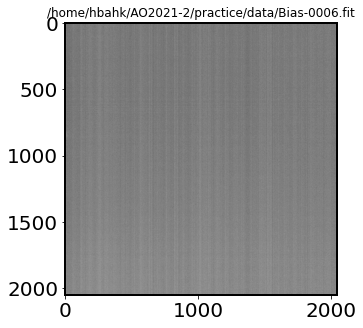

In [31]:
#Plot the Sample image of bias image
File = Biaslist[5]
sample_hdul = fits.open(File)
sample_data = sample_hdul[0].data

fig,ax = plt.subplots(1,1,figsize=(13,5))
vmin = np.mean(sample_data) - 40
vmax = np.mean(sample_data) + 40
im = ax.imshow(sample_data,
                  cmap='gray',vmin=vmin,vmax=vmax)
ax.set_title(File,fontsize=12)

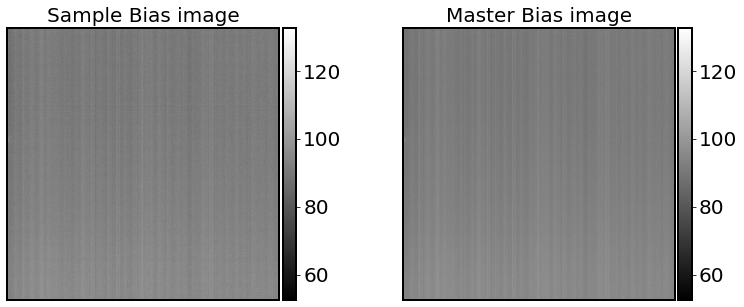

In [32]:
#Median combine Bias image    
    
Master_bias = []
for i in range(0,len(Biaslist)):
    hdul = fits.open(Biaslist[i])
    bias_data = hdul[0].data
    bias_data = np.array(bias_data).astype('float64')
    Master_bias.append(bias_data)
MASTER_Bias = np.median(Master_bias,axis=0)


#Let's make Master bias image fits file

#Making header part
bias_header = hdul[0].header
bias_header['OBJECT'] = 'Bias'
bias_header['COMMENT'] = '{0} bias images are median combined on '.format(len(Biaslist))\
+ datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')


SAVE_bias = os.path.join(subpath,'Master_Bias.fits' )
fits.writeto(SAVE_bias,MASTER_Bias,header = bias_header,overwrite=True)


#Plot Master bias 
fig,ax = plt.subplots(1,2,figsize=(13,5))
im = ax[0].imshow(sample_data,
                  cmap='gray',
                  vmin=vmin,vmax=vmax)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
ax[0].set_title('Sample Bias image',fontsize=20)
ax[0].tick_params(labelbottom=False,labelleft=False,
                 bottom=False,left=False)
plt.colorbar(im,cax=cax)

im1 = ax[1].imshow(MASTER_Bias,
                   cmap='gray',
                   vmin=vmin,vmax=vmax)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right",size='5%',pad=0.05)
ax[1].set_title('Master Bias image',fontsize=20)
ax[1].tick_params(labelbottom=False,labelleft=False,
                  bottom=False,left=False)
plt.colorbar(im1,cax=cax)


## 1.2Derive Readout Noise (RN)

In [27]:
#Let's derive RN

#Bring Bias1 data
hdul1 = fits.open(Biaslist[0]) 
bias1 = hdul1[0].data            
bias1 = np.array(bias1).astype('float64')

#Bring Bias2 data
hdul2 = fits.open(Biaslist[1])
bias2 = hdul2[0].data
bias2 = np.array(bias2).astype('float64')

#derive the differential image
dbias = bias2 - bias1

#Bring Gain 
gain = 1.5 #e/ADU

#Calculate RN
RN = np.std(dbias)*gain / np.sqrt(2)
print('Readout Noise is {0:.2f}'.format(RN))



#Do it for all bias data
Name = []
RN = []
for i in range(len(Biaslist)-1):
    hdul1 = fits.open(Biaslist[i])
    bias1 = hdul1[0].data
    bias1 = np.array(bias1).astype('float64')
    hdul2 = fits.open(Biaslist[i+1])
    bias2 = hdul2[0].data
    bias2 = np.array(bias2).astype('float64')
    dbias = bias2 - bias1

    print(i,'st',np.std(dbias)*gain / np.sqrt(2))
    RN.append(np.std(dbias)*gain / np.sqrt(2))
print(np.mean(RN))    
RN = np.mean(RN)

Readout Noise is 6.33
0 st 6.3278860263533705
1 st 6.339544359427237
2 st 6.34543518327795
3 st 6.3435130227940055
4 st 6.341916407213414
5 st 6.3418654482137455
6 st 6.3388243002099784
7 st 6.344741135574891
6.340465735383074


## 1.3 Making Master Dark
Master dark = median combine([Dark image1 - master bias, Dark image2 - master bias, Dark image3 - master bias,...])

In [34]:
#Checking what exposure time is taken
exptime = []

for i in range(len(Darklist)):
    hdul = fits.open(Darklist[i])[0]
    header = hdul.header
    exp = header['EXPTIME']
    exptime.append(exp)
exptime = set(exptime)    
exptime = sorted(exptime)
print(exptime)

[3.0, 5.0, 10.0, 20.0, 60.0, 100.0, 120.0, 240.0]


In [35]:
#Bring master bias
Mbias = fits.open(SAVE_bias)[0].data
Mbias = np.array(Mbias).astype('float64')

#Making master dark image for each exposure time
for exp_i in exptime:
    Master_dark = []
    for i in range(len(Darklist)):
        hdul = fits.open(Darklist[i])[0]
        header = hdul.header
        exp = header['EXPTIME']

        if exp == exp_i:
            data = hdul.data
            data = np.array(data).astype('float64')
            bdata = data - Mbias #Bias subtracting
            Master_dark.append(bdata)
            
    MASTER_dark = np.median(Master_dark,axis=0)
    header['COMMENT'] = 'Bias_subtraction is done' + datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')
    header["COMMENT"]='{0} dark images are median combined on '.format(len(Master_dark))\
    + datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')
    SAVE_dark = os.path.join(subpath,'Master_Dark_'+str(exp_i)+'s.fits')
    fits.writeto(SAVE_dark,MASTER_dark,header = header,overwrite=True)
    print(exp_i ,'s is done!', SAVE_dark,' is made.')

3.0 s is done! /home/hbahk/AO2021-2/practice/data/Master_Dark_3.0s.fits  is made.
5.0 s is done! /home/hbahk/AO2021-2/practice/data/Master_Dark_5.0s.fits  is made.
10.0 s is done! /home/hbahk/AO2021-2/practice/data/Master_Dark_10.0s.fits  is made.
20.0 s is done! /home/hbahk/AO2021-2/practice/data/Master_Dark_20.0s.fits  is made.
60.0 s is done! /home/hbahk/AO2021-2/practice/data/Master_Dark_60.0s.fits  is made.
100.0 s is done! /home/hbahk/AO2021-2/practice/data/Master_Dark_100.0s.fits  is made.
120.0 s is done! /home/hbahk/AO2021-2/practice/data/Master_Dark_120.0s.fits  is made.
240.0 s is done! /home/hbahk/AO2021-2/practice/data/Master_Dark_240.0s.fits  is made.


## 1.4 Making Master Flat

### 1.4-1 Checking whether Flat image is shifted or not
The flat image could shift little by little depending on where the telescope is pointing. Because different images may have different flats to use, it can be dangerous to median combine all the flats image taken overnight. Let's do **quick** and **rough** check whethere there is flat shift.

By using local peak location, I will check whether there was the flat shift or not. 

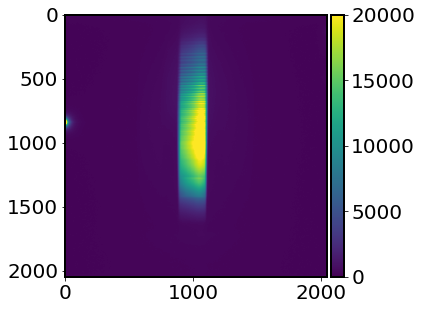

In [36]:
#Plot the flat image
fig,ax = plt.subplots(1,1,figsize=(5,5))

hdul = fits.open(Flatlist[4])[0]
data = hdul.data
im = ax.imshow(data,vmin=0, vmax = 20000)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size='5%',pad=0.05)
plt.colorbar(im,cax=cax)

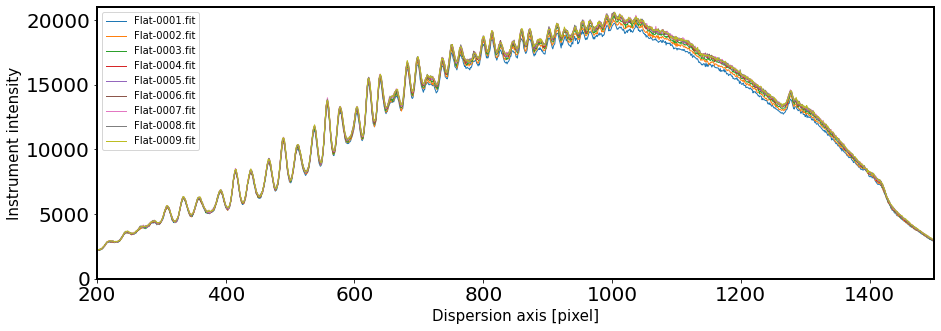

In [37]:
#Do bias and dark subtraction
Mbias = fits.open(SAVE_bias)[0].data
Mbias = np.array(Mbias).astype('float64')


fig,ax = plt.subplots(1,1,figsize=(15,5))

for i in range(len(Flatlist)):
    hdul = fits.open(Flatlist[i])[0]
    data = hdul.data
    flat = np.median(data[:,980:1020],axis=1)
    
    ax.plot(flat,label=Flatlist[i].split('/')[-1],lw=1)
    ax.set_xlim(200,1500)
    ax.legend(fontsize=10)
    ax.set_ylim(0,21000)
    ax.set_ylabel('Instrument intensity')
    ax.set_xlabel('Dispersion axis [pixel]')
    

####  Finding local peak

/home/hbahk/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0.5, 1.0, 'Total 17 peakes')

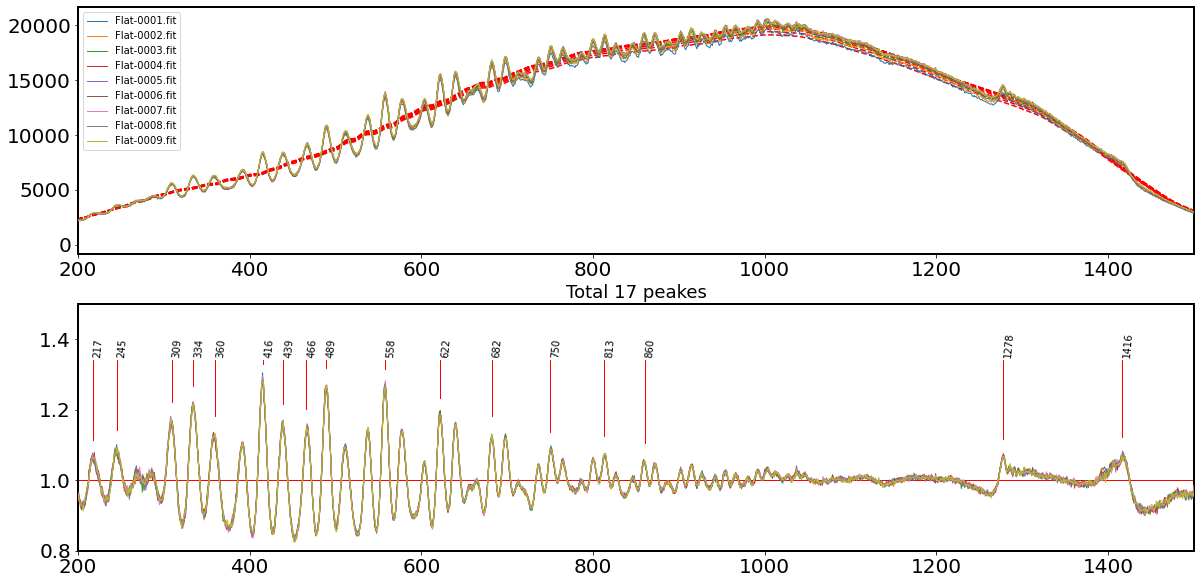

In [38]:
fig,ax = plt.subplots(2,1,figsize=(20,10))

def smooth(y,width):    # Moving box averaging
    box = np.ones(width)/width
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth   

Coor_shift = []
for i in range(len(Flatlist)):
    hdul = fits.open(Flatlist[i])[0]
    data = hdul.data
    flat = np.median(data[:,980:1020],axis=1)
    
    ax[0].plot(flat,label=Flatlist[i].split('/')[-1],lw=1,zorder=20)
    ax[0].set_xlim(200,1500)
    ax[0].legend(fontsize=10)
    
    
    sflat = smooth(flat,100)
    nor_flat = flat/sflat # flat field after the large-scale curve is divied
    ax[0].plot(sflat,color='r',ls='--')
    
    ax[1].plot(nor_flat,lw=1,zorder=15)
    ax[1].set_xlim(200,1500)
    ax[1].set_ylim(0.8,1.5)
    ax[1].axhline(1,color='r',lw=1)    
    
    coordinates = peak_local_max(nor_flat,min_distance=20,threshold_abs=1.05) 
    Coor_shift.append(coordinates)
    

    
for i in coordinates:
    ax[1].annotate(i[0],(i,1.35),
                  fontsize=10,rotation=85)
    ax[1].plot([i[0],i[0]],
            [nor_flat[i]+0.05,1.34],
            color='r',lw=1)
ax[1].set_title('Total {0} peakes'.format(int(len(coordinates))))        

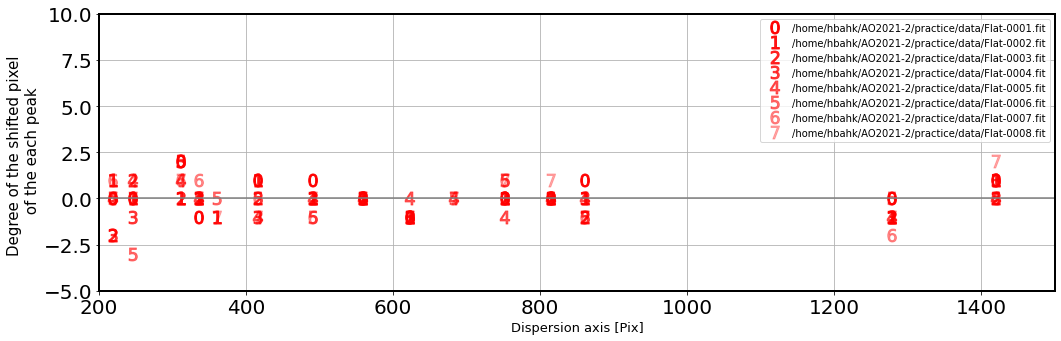

In [39]:
fig,ax = plt.subplots(1,1,figsize=(15,5))


reference_coor = sorted(Coor_shift[0])   
for i in range(len(Coor_shift)-1):
    coor_i = Coor_shift[i+1]
    x_shift = []
    y_shift = []
    for k in range(len(reference_coor)):
        for t in range(len(coor_i)):
            if abs(reference_coor[k]-coor_i[t]) <5 :
                y_shift.append(reference_coor[k]-coor_i[t])
                x_shift.append(reference_coor[k])
    ax.plot(x_shift,y_shift,ls='',marker='${0}$'.format(int(i)),
               markersize=13,color='r',alpha=1-i*0.1,label=Flatlist[i])  
ax.set_xlabel('Dispersion axis [Pix]',fontsize=13)    
ax.set_xlim(200,1500)    
ax.set_ylim(-5,10)
ax.set_ylabel('Degree of the shifted pixel \n of the each peak')
ax.axhline(0,color='gray')
ax.grid()
ax.legend(fontsize=10)

plt.tight_layout()

### 1.4-2 Median combine flat image to make Master Flat

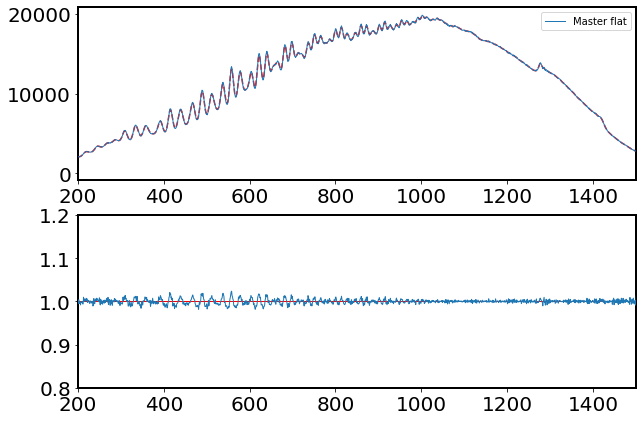

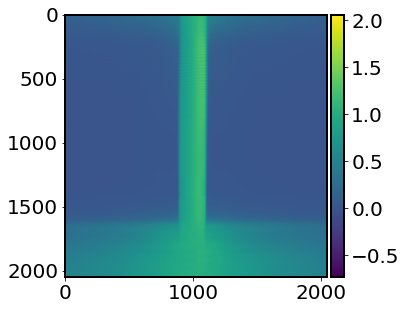

In [40]:
#Bring Master bias & Dark

biasfile = os.path.join(subpath,'Master_Bias.fits')
Mbias = fits.open(biasfile)[0].data
Mbias = np.array(Mbias).astype('float64')

darkfile = os.path.join(subpath,'Master_Dark_20.0s.fits')
Mdark = fits.open(darkfile)[0].data 
Mdark = np.array(Mdark).astype('float64')


#Make master Flat image
Master_flat = []
for i in range(len(Flatlist)):
    hdul = fits.open(Flatlist[i])[0]
    header = hdul.header
    
    data = hdul.data
    data = np.array(data).astype('float64')
    
    bdata = data - Mbias    
    dbdata = bdata - Mdark
    Master_flat.append(dbdata)
    
MASTER_flat = np.median(Master_flat,axis=0)
header['COMMENT'] = 'Bias_subtraction is done' + datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')
header["COMMENT"]='{0} dark images are median combined on '.format(len(Master_dark))\
+ datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')+ 'with '+' Master_Dark_'+str(exp)+'s.fits'




flat = np.median(MASTER_flat[:,900:1100],axis=1)
fig,ax=plt.subplots(2,1,figsize=(10,7))
ax[0].plot(flat,label='Master flat',lw=1,zorder=20)
ax[0].set_xlim(200,1500)
ax[0].legend(fontsize=10)


sflat = smooth(flat,5)
nor_flat = flat/sflat
ax[0].plot(sflat,color='r',ls='--')

ax[1].plot(nor_flat,lw=1,zorder=15)
ax[1].set_xlim(200,1500)
ax[1].set_ylim(0.8,1.2)
ax[1].axhline(1,color='r',lw=1)    

nor_flat2d = []
for i in range(len(MASTER_flat[0])):
    nor_flat2d.append(MASTER_flat[:,i] / sflat)
    
nor_flat2d = np.array(nor_flat2d).T    
header['COMMENT'] = 'Normalized' + datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')

SAVE_flat = os.path.join(subpath,'Master_Flat.fits')
fits.writeto(SAVE_flat,nor_flat2d,header = header,overwrite=True)



fig,ax = plt.subplots(1,1,figsize=(5,5))
im=ax.imshow(nor_flat2d)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size='5%',pad=0.05)
plt.colorbar(im,cax=cax)


## 1.5 Master Calibration image
### Check wavelength Calibration image shift

I will check the wavelength calibration image shift with the same manner done for flat image.

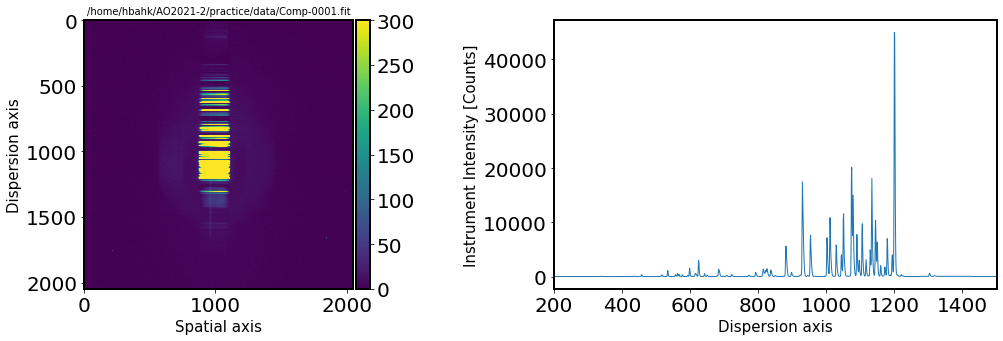

In [41]:
#Bring Master bias & Dark

biasfile = os.path.join(subpath,'Master_Bias.fits')
Mbias = fits.open(biasfile)[0].data
Mbias = np.array(Mbias).astype('float64')

darkfile = os.path.join(subpath,'Master_Dark_10.0s.fits')
Mdark = fits.open(darkfile)[0].data 
Mdark = np.array(Mdark).astype('float64')


#Plot the Comparison image
fig,ax = plt.subplots(1,2,figsize=(15,5))

hdul = fits.open(Complist[0])[0]
data = hdul.data
data = np.array(data).astype('float64')
data = data - Mbias - Mdark

im = ax[0].imshow(data,vmin=0, vmax = 300)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right",size='5%',pad=0.05)
plt.colorbar(im,cax=cax)
ax[0].set_title(Complist[0],fontsize=10)
ax[0].set_xlabel('Spatial axis')
ax[0].set_ylabel('Dispersion axis')



#Cut the spectrum along the dispersion direction
ComSpec = np.median(data[:,980:1020],axis=1)
ax[1].plot(ComSpec,lw=1)
ax[1].set_xlim(200,1500)
ax[1].set_xlabel('Dispersion axis')
ax[1].set_ylabel('Instrument Intensity [Counts]')
    
plt.tight_layout()

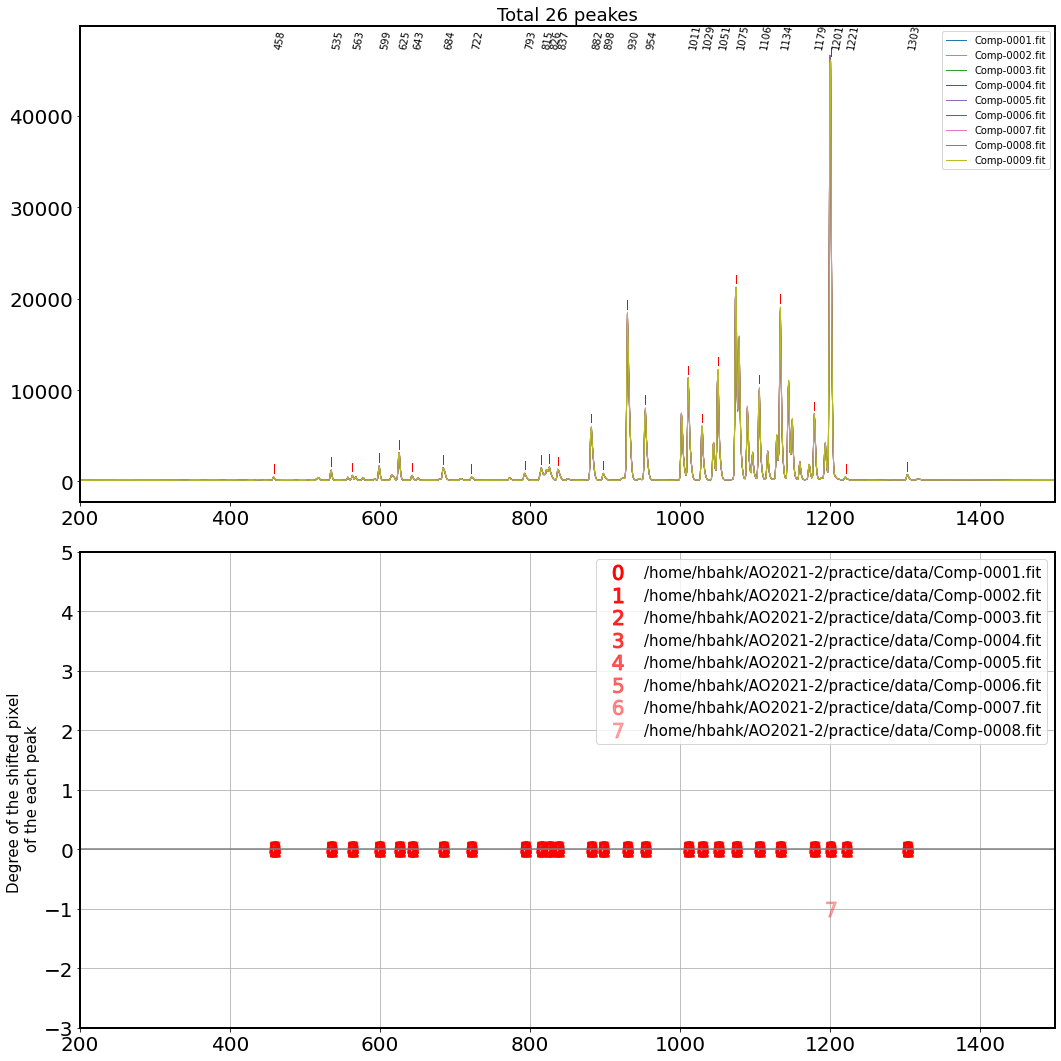

In [42]:
#Find the local peak for each image

fig,ax = plt.subplots(2,1,figsize=(15,15))
Coor_shift = []
for i in range(len(Complist)):
    hdul = fits.open(Complist[i])[0]
    data = hdul.data
    data = np.array(data).astype('float64')
    neon = np.median(data[:,980:1020],axis=1)
    
    ax[0].plot(neon,label=Complist[i].split('/')[-1],lw=1)
    ax[0].set_xlim(200,1500)
    ax[0].legend(fontsize=10)
    
    
    x = np.arange(0,len(neon))
    coordinates = peak_local_max(neon, min_distance=10, 
                                 threshold_abs= max(neon)*0.01)
    
    Coor_shift.append(coordinates)
    
    

ax[0].set_title('Total {0} peakes'.format(int(len(coordinates))))

for i in coordinates:
    ax[0].annotate(i[0],(i,max(neon)+ max(neon)*0.03),
                  fontsize=10,rotation=80)
    ax[0].plot([i,i],
            [neon[i] + max(neon)*0.01, neon[i] + max(neon)*0.03],
            color='r',lw=1)
    
    
reference_coor = sorted(Coor_shift[0])    
     
for i in range(len(Coor_shift)-1):
    coor_i = Coor_shift[i+1]
    x_shift = []
    y_shift = []
    for k in range(len(reference_coor)):
        for t in range(len(coor_i)):
            if abs(reference_coor[k]-coor_i[t]) <5 :
                y_shift.append(reference_coor[k]-coor_i[t])
                x_shift.append(reference_coor[k])
    ax[1].plot(x_shift,y_shift,ls='',marker='${0}$'.format(int(i)),
               markersize=15,color='r',alpha=1-i*0.1, label=Complist[i])    
ax[1].set_xlim(200,1500)    
ax[1].set_ylim(-3,5)
ax[1].set_ylabel('Degree of the shifted pixel \n of the each peak')
ax[1].axhline(0,color='gray')
ax[1].grid()
ax[1].legend()

plt.tight_layout()

### Median combine Comparison Lamp image

In [43]:
Master_Comp = []
for i in range(len(Complist)):
    hdul = fits.open(Complist[i])[0]
    header = hdul.header    
    data = hdul.data
    data = data - Mbias - Mdark

    Master_Comp.append(data)
    
MASTER_Comp = np.median(Master_Comp,axis=0)
SAVE_comp = os.path.join(subpath,'Master_Neon.fits')
fits.writeto(SAVE_comp,MASTER_Comp,header = header,overwrite=True)


## 1.6 Bias subtraction & Dark subtraction (Pre-Processing)

/tmp/ipykernel_1330731/744550187.py:29: RuntimeWarning: divide by zero encountered in true_divide
  fdbobjdata = dbobjdata/Mflat
/tmp/ipykernel_1330731/744550187.py:29: RuntimeWarning: invalid value encountered in true_divide
  fdbobjdata = dbobjdata/Mflat


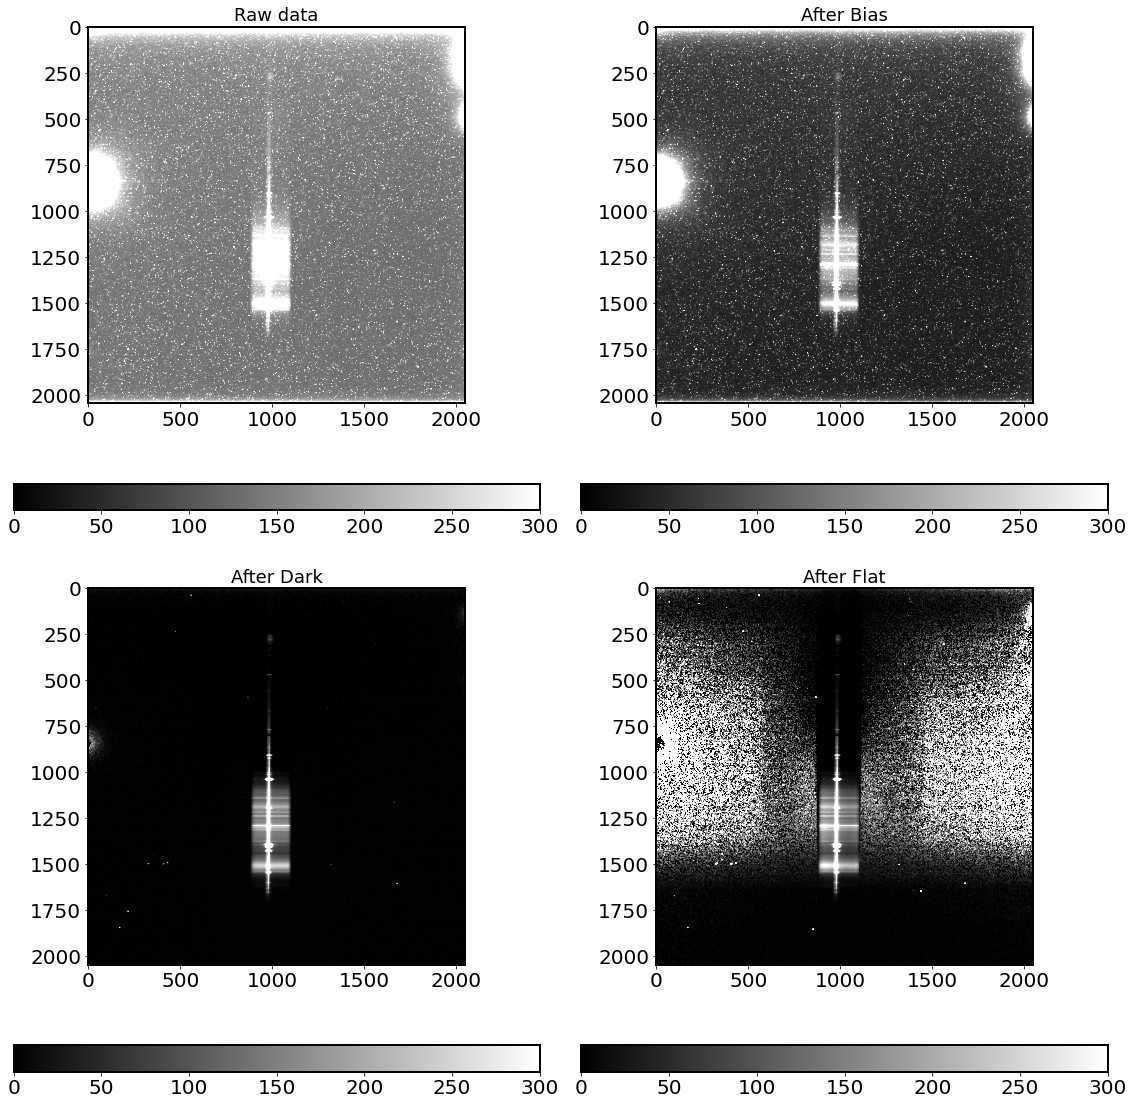

In [44]:
#Bring the sample image 
raw_data = os.path.join(subpath,'NGC6543-0001.fit')
objhdul = fits.open(raw_data)
raw_data = objhdul[0].data

#Bring Master Bias
biasfile = os.path.join(subpath,'Master_Bias.fits')
Mbias = fits.open(biasfile)[0].data
Mbias = np.array(Mbias).astype('float64')

#Bring Master Dark
darkfile = os.path.join(subpath,'Master_Dark_60.0s.fits')
Mdark = fits.open(darkfile)[0].data 
Mdark = np.array(Mdark).astype('float64')

#Bring Master Flat
flatfile = os.path.join(subpath,'Master_Flat.fits')
Mflat = fits.open(flatfile)[0].data 
Mflat = np.array(Mflat).astype('float64')


#Bias subtracting
bobjdata = raw_data - Mbias 

#Dark_subtracting
dbobjdata = bobjdata - Mdark

#Flat fielding
fdbobjdata = dbobjdata/Mflat


fig,ax = plt.subplots(2,2,figsize=(16,16))
ax1 = ax[0,0].imshow(raw_data,vmin=0,vmax=300,cmap='gray')
fig.colorbar(ax1, ax=ax[0,0],orientation = 'horizontal')
ax[0,0].set_title('Raw data')



ax2 = ax[0,1].imshow(bobjdata,vmin=0,vmax=300,cmap='gray')
fig.colorbar(ax2, ax=ax[0,1],orientation = 'horizontal')
ax[0,1].set_title('After Bias')

ax3 = ax[1,0].imshow(dbobjdata,vmin=0,vmax=300,cmap='gray')
fig.colorbar(ax3, ax=ax[1,0],orientation = 'horizontal')
ax[1,0].set_title('After Dark')

ax4 = ax[1,1].imshow(fdbobjdata,vmin=0,vmax=300,cmap='gray')
fig.colorbar(ax3, ax=ax[1,1],orientation = 'horizontal')
ax[1,1].set_title('After Flat')

plt.tight_layout()

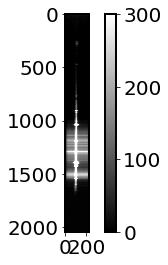

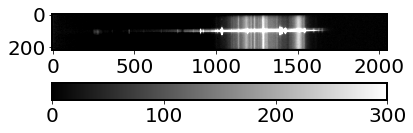

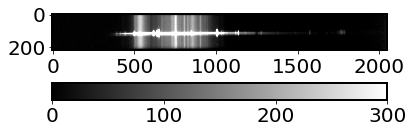

In [45]:
#Trimming
Trim = dbobjdata[:,880:1100]
fig,ax = plt.subplots(1,1)
im = ax.imshow(Trim,vmin=0,vmax=300,cmap='gray')
fig.colorbar(im, ax=ax)

Turn = Trim.T
fig,ax = plt.subplots(1,1)
im = ax.imshow(Turn,vmin=0,vmax=300,cmap='gray')
fig.colorbar(im, ax=ax,orientation = 'horizontal')

Flip = np.flip(Turn)
fig,ax = plt.subplots(1,1)
im = ax.imshow(Flip,vmin=0,vmax=300,cmap='gray')
fig.colorbar(im, ax=ax,orientation = 'horizontal')


In [46]:
#Do it for all object image

OBJ = np.concatenate([Objectlist,Standlist])
for i in range(len(OBJ)):
    #Bring the sample image 
    objhdul = fits.open(OBJ[i])
    raw_data = objhdul[0].data
    header = objhdul[0].header

    #Bring Master Bias
    biasfile = os.path.join(subpath,'Master_Bias.fits')
    Mbias = fits.open(biasfile)[0].data
    Mbias = np.array(Mbias).astype('float64')

    #Bring Master Dark
    EXPTIME = objhdul[0].header['EXPTIME']
    darkfile = os.path.join(subpath,'Master_Dark_{0:.1f}s.fits'.format(EXPTIME))
    Mdark = fits.open(darkfile)[0].data 
    Mdark = np.array(Mdark).astype('float64')

    #Bias subtracting
    bobjdata = raw_data - Mbias 

    #Dark_subtracting
    dbobjdata = bobjdata - Mdark
    
    #Trim the image 
    Trim = dbobjdata[:,880:1100]
    
    #Rotate and Filp the image 
    Turn = Trim.T
    Flip = np.flip(Turn)
    
    #Add header comment
    header['COMMENT'] = 'Bias_subtraction is done' + datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')
    header["COMMENT"]='{0} dark images are median combined on '.format(len(Master_dark))\
    + datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')+ 'with '+' Master_Dark_'+str(exp)+'s.fits'
    
    #Save the image
    SAVE_name = os.path.join(subpath,'p'+ OBJ[i].split('/')[-1]+'s')
    fits.writeto(SAVE_name,Flip,header = header,overwrite=True)
    print(SAVE_name,' is made!')

    
#Trim the Neon image
Master_comparison = os.path.join(subpath,'Master_Neon.fits')
hdul = fits.open(Master_comparison)[0]
data = hdul.data
tdata = data[:,880:1100]
Turn = tdata.T
Flip = np.flip(Turn)

fits.writeto(os.path.join(subpath,'pMaster_Neon.fits'),Flip,header=hdul.header,overwrite=True)

/home/hbahk/AO2021-2/practice/data/pNGC6543-0001.fits  is made!
/home/hbahk/AO2021-2/practice/data/pHR9087-0001.fits  is made!


# 2. Spectroscopic data reduction
# 2-1. Extract the Spectrum

## Identification of Object's peak & Set the area of background

Text(0, 0.5, 'Spatial axis \n [pixel]')

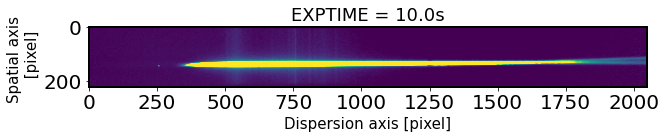

In [44]:
#Bring the sample image

# OBJECTNAME = os.path.join(subpath,'pNGC6543-0001.fits')
OBJECTNAME = os.path.join(subpath,'pHR9087-0001.fits')
hdul = fits.open(OBJECTNAME)[0]
obj = hdul.data
header = hdul.header
EXPTIME = header['EXPTIME']
fig,ax = plt.subplots(1,1,figsize=(10,15))
ax.imshow(obj,vmin=0,vmax=300)
ax.set_title('EXPTIME = {0}s'.format(EXPTIME))
ax.set_xlabel('Dispersion axis [pixel]')
ax.set_ylabel('Spatial axis \n [pixel]')


[[135]]


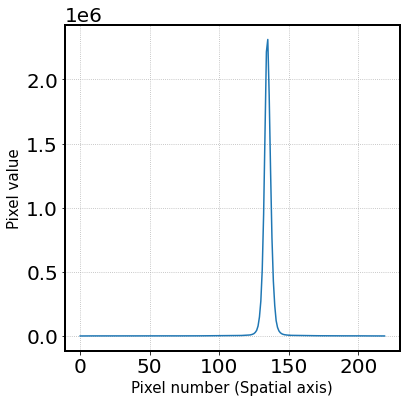

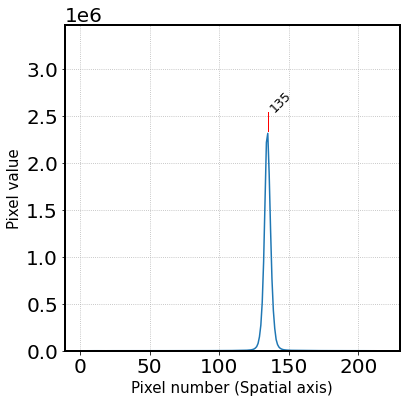

Pixel coordinatate in spatial direction = 135


In [45]:
#Let's find the peak

#Plot the spectrum along the spatial direction
lower_cut = 700
upper_cut = 750
apall_1 = np.sum(obj[:,lower_cut:upper_cut],axis=1)

fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(apall_1)
ax.set_xlabel('Pixel number (Spatial axis)')
ax.set_ylabel('Pixel value')
ax.grid(ls=':')

#Find the peak

peak_pix = peak_local_max(apall_1, num_peaks=10,
                          min_distance = 30,
                          threshold_abs=np.median(apall_1))
print(peak_pix)

fig,ax = plt.subplots(1,1,figsize=(6,6))
x = np.arange(0, len(apall_1))
ax.plot(x,apall_1)
ax.set_xlabel('Spatial axis')

peak = []
for i in peak_pix:
    ax.plot((i, i), 
            (apall_1[i]+0.01*max(apall_1),apall_1[i]+0.1*max(apall_1)),
            color='r', ls='-', lw=1)
    ax.annotate(i[0], (i[0], apall_1[i][0]+0.1*max(apall_1)),
            fontsize='small', rotation=45)
    peak.append(apall_1[i])

order = peak.index(max(peak))
pix_peak = peak_pix[order] 

ax.grid(ls=':')
ax.set_xlabel('Pixel number (Spatial axis)')
ax.set_ylabel('Pixel value')
ax.set_ylim(0, apall_1[pix_peak]*1.5)

plt.show()

print('Pixel coordinatate in spatial direction = {0}'.format(pix_peak[0]))

Peak pixel is 135 pix
ap_sky =  [ 75 105 165 195]
x_sky =  [ 75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194]
sky_val =  [1202. 1099. 1090. 1367. 1179. 1306. 1307. 1399. 1331. 1279. 1369. 1324.
 1386. 1519. 1540. 1451. 1815. 1528. 1706. 1666. 1828. 1794. 1709. 1976.
 1995. 2069. 2161. 2036. 2304. 2466. 2438. 2473. 2596. 2368. 2159. 2213.
 2320. 2164. 1971. 1881. 1788. 1893. 1675. 1623. 1732. 1703. 1753. 1529.
 1485. 1557. 1409. 1348. 1373. 1321. 1260. 1287. 1232. 1347. 1121. 1156.]
Sky area is from 75 pix ~ 105 pix and 165 pix ~ 195 pix


(0.0, 1155983.0)

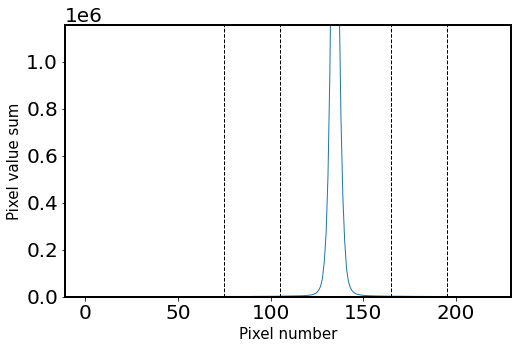

In [46]:
#select the sky area
peak = pix_peak[0] # Center
print('Peak pixel is {0} pix'.format(pix_peak[0]))

lower_limit = 30
upper_limit = 60
ap_sky = np.array([peak-upper_limit,peak-lower_limit,
                   peak+lower_limit,peak+upper_limit]) #Setting the Sky area
print('ap_sky = ',ap_sky)

x_sky = np.hstack((np.arange(ap_sky[0], ap_sky[1]), 
                   np.arange(ap_sky[2], ap_sky[3])))  #Bring the 
print('x_sky = ',x_sky)

sky_val = np.hstack((apall_1[ap_sky[0]:ap_sky[1]], 
                     apall_1[ap_sky[2]:ap_sky[3]]))
print('sky_val = ',sky_val)

print('Sky area is from {0} pix ~ {1} pix \
and {2} pix ~ {3} pix'.format(ap_sky[0], ap_sky[1], ap_sky[2], ap_sky[3]))


#Plot the sky area
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
title_str = r'Skyfit: {:s} order {:d} ({:.1f}-sigma {:d}-iters)'
ax.plot(x, apall_1, lw=1)
[ax.axvline(i, lw=1, color='k', ls='--') for i in ap_sky]

ax.set_xlabel('Pixel number')
ax.set_ylabel('Pixel value sum')
ax.set_ylim(0,apall_1[pix_peak]*0.5)

Text(0.5, 1.0, 'Skyfit: Chebyshev order 3 (3.0-sigma 5-iters)')

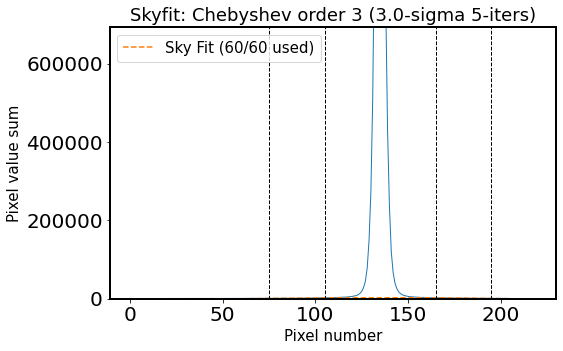

In [47]:
#Sigma Clipping
Sigma = 3
clip_mask = sigma_clip(sky_val,
                       sigma= Sigma,
                       maxiters= 5).mask

#Fit the sky
ORDER_APSKY = 3
coeff_apsky, fitfull = chebfit(x_sky[~clip_mask], 
                               sky_val[~clip_mask],
                               deg=ORDER_APSKY,
                               full=True)
sky_fit = chebval(x, coeff_apsky) 

#Calculate the RMS of Fit
residual = fitfull[0][0] 
fitRMS = np.sqrt(residual/len(x_sky[~clip_mask]))


n_sky = len(x_sky)
n_rej = np.count_nonzero(clip_mask)

#Plot the sky area & fitted sky
fig,ax = plt.subplots(1,1,figsize=(8, 5))

ax.plot(x, apall_1, lw=1)
ax.plot(x, sky_fit, ls='--',
        label='Sky Fit ({:d}/{:d} used)'.format(n_sky - n_rej, n_sky))
ax.plot(x_sky[clip_mask], sky_val[clip_mask], marker='x', ls='', ms=10)
[ax.axvline(i, lw=1, color='k', ls='--') for i in ap_sky]


title_str = r'Skyfit: {:s} order {:d} ({:.1f}-sigma {:d}-iters)'
ax.set_xlabel('Pixel number')
ax.set_ylabel('Pixel value sum')
ax.set_ylim(0,apall_1[pix_peak]*0.3)
ax.legend()
ax.set_title(title_str.format('Chebyshev', ORDER_APSKY,
                              Sigma, 5))

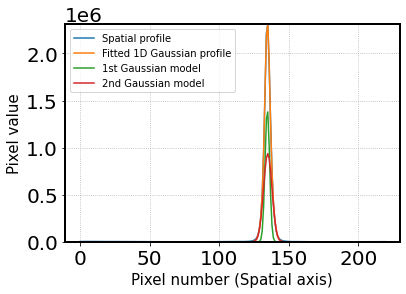

In [48]:
#Finding the peak center by fitting the gaussian 1D function again

sub_apall_1 = apall_1 - sky_fit #Profile - sky

OUTPIX = 50 # number of pixels to rule out outermost area in spacial direction
xx = x[OUTPIX:-OUTPIX]
yy = sub_apall_1[OUTPIX:-OUTPIX]

# double gaussian model
g1= Gaussian1D(amplitude=sub_apall_1[pix_peak], 
                    mean = pix_peak,
                    stddev = 15* gaussian_fwhm_to_sigma)

g2 = Gaussian1D(amplitude=sub_apall_1[pix_peak], 
                    mean = pix_peak+20,
                    stddev = 15* gaussian_fwhm_to_sigma)

g_init = g1 + g2

fitter = LevMarLSQFitter()
fitted = fitter(g_init, xx, yy)

params = [[fitted[i].amplitude.value, fitted[i].mean.value, fitted[i].stddev.value] for i in range(2)]
# params[0] is list containing parameters for 1st component.
# params[1] is for 2nd.

fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(0, len(apall_1))
ax.plot(x, sub_apall_1, label='Spatial profile')

gg1 = Gaussian1D(*params[0]) # 1st comp.
gg2 = Gaussian1D(*params[1]) # 2nd comp.
ggg = gg1 + gg2

ax.plot(x, ggg(x), label='Fitted 1D Gaussian profile')
ax.plot(x, gg1(x), label='1st Gaussian model')
ax.plot(x, gg2(x), label='2nd Gaussian model')
ax.grid(ls=':')
ax.set_xlabel('Pixel number (Spatial axis)')
ax.set_ylabel('Pixel value')
ax.set_ylim(0, sub_apall_1[pix_peak])
ax.legend(loc=2,fontsize=10)
plt.show()

center_pix = params[0][1]

In [49]:
np.array(params)[:,1]




array([134.66049006, 134.97947878])

In [50]:
#Trace the Aperture (Peak) along the wavelength
#Repeat the above process for all wavelength bands.
aptrace = []
aptrace_fwhm = []
STEP_AP = 10  
N_AP = len(obj[0])//STEP_AP
FWHM_AP = 10
peak = center_pix
for i in range(N_AP - 1):
    lower_cut, upper_cut = i*STEP_AP, (i+1)*STEP_AP
    apall_i = np.sum(obj[:, lower_cut:upper_cut], axis=1)
    sky_val = np.hstack( (apall_i[ap_sky[0]:ap_sky[1]], 
                          apall_i[ap_sky[2]:ap_sky[3]]) )
    clip_mask = sigma_clip(sky_val,
                           sigma=3,
                           maxiters=5).mask
    coeff, fitfull = chebfit(x_sky[~clip_mask], 
                             sky_val[~clip_mask],
                             deg=ORDER_APSKY,
                             full=True)
    apall_i -= chebval(x,coeff)  # Object profile - the fitted sky #apall_i = apall_i - chebval(x,coeff)
    
    search_min = int(peak - 3*FWHM_AP)
    search_max = int(peak + 3*FWHM_AP)
    cropped = apall_i[search_min:search_max]
    x_cropped = np.arange(len(cropped))
    
    peak_pix = peak_local_max(cropped,
                              min_distance=FWHM_AP,
                              num_peaks=1)
 
    if len(peak_pix)==0: #만약 스펙트럼의 중심을 찾을 수 없으면
        aptrace.append(np.nan)
        aptrace_fwhm.append(0)
        continue
        
    else:
        peak_pix = peak_pix[0][0] #스펙트럼의 중심을 찾았다면

        g_init = Gaussian1D(amplitude=cropped[peak_pix], #가우시안 피팅을 해서 중심을 다시 찾자
                            mean = peak_pix,
                            stddev = FWHM_AP * gaussian_fwhm_to_sigma,
                            bounds={'amplitude':(0, 2*cropped[peak_pix]) ,
                                   'mean':(peak_pix-3*FWHM_AP, peak_pix+3*FWHM_AP),
                                   'stddev':(0.00001, FWHM_AP*gaussian_fwhm_to_sigma)})
        fitted = fitter(g_init, x_cropped, cropped)
        center_pix_new = fitted.mean.value + search_min
        aptrace_fwhm.append(fitted.fwhm)
        aptrace.append(center_pix_new)    
        
aptrace = np.array(aptrace)
aptrace_fwhm = np.array(aptrace_fwhm)          




Text(0, 0.5, 'Spatial axis')

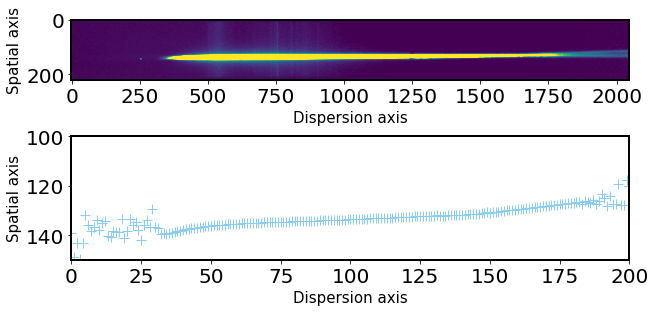

In [51]:
#Plot the center of profile peak
fig,ax = plt.subplots(2,1,figsize=(10,5))
ax[0].imshow(obj,vmin=0,vmax=300)
ax[0].set_xlabel('Dispersion axis',fontsize=15)
ax[0].set_ylabel('Spatial axis',fontsize=15)

ax[1].plot(aptrace,ls='', marker='+', ms=10,color='lightskyblue')
ax[1].set_xlim(0,200)
ax[1].set_ylim(150,100) #확대해보면 찌글찌글하다
ax[1].set_xlabel('Dispersion axis',fontsize=15)
ax[1].set_ylabel('Spatial axis',fontsize=15)
        

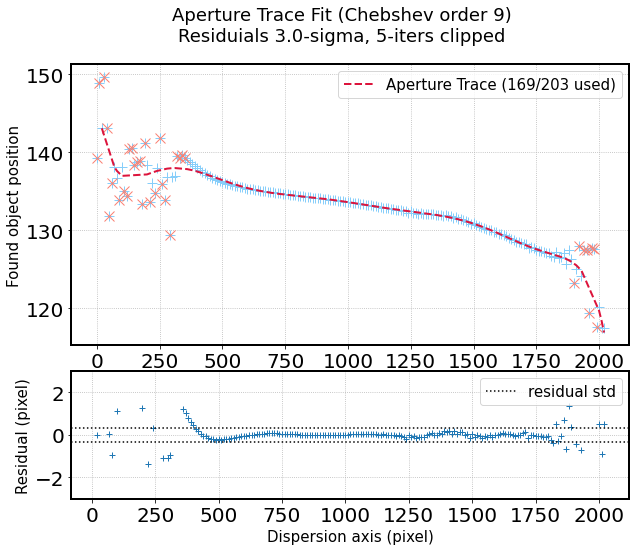

In [52]:
#Fitting the peak with Chebyshev function

ORDER_APTRACE = 9
SIGMA_APTRACE = 3
ITERS_APTRACE = 5 #When sigma_clipping

#Fitting the line
x_aptrace = np.arange(N_AP-1) * STEP_AP
coeff_aptrace = chebfit(x_aptrace, aptrace, deg=ORDER_APTRACE)

#Sigma clipping
resid_mask = sigma_clip(aptrace - chebval(x_aptrace, coeff_aptrace), 
                        sigma=SIGMA_APTRACE, maxiters=ITERS_APTRACE).mask

#Fitting the peak again after sigma clipping
x_aptrace_fin = x_aptrace[~resid_mask]
aptrace_fin = aptrace[~resid_mask]
coeff_aptrace_fin = chebfit(x_aptrace_fin, aptrace_fin, deg=ORDER_APTRACE)   

fit_aptrace_fin   = chebval(x_aptrace_fin, coeff_aptrace_fin)
resid_aptrace_fin = aptrace_fin - fit_aptrace_fin
del_aptrace = ~np.in1d(x_aptrace, x_aptrace_fin) # deleted points #x_aptrace에서 x_aptrace_fin이 없으면 True
'''
test = np.array([0, 1, 2, 5, 0])
states = [0, 2]
mask = np.in1d(test, states)
mask
array([ True, False,  True, False,  True])
'''


#Plot the Fitted line & residual
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3, 1)
ax1 = plt.subplot(gs[0:2])
ax2 = plt.subplot(gs[2])

ax1.plot(x_aptrace, aptrace, ls='', marker='+', ms=10,color='lightskyblue')
ax1.plot(x_aptrace_fin, fit_aptrace_fin, ls='--',color='crimson',zorder=10,lw=2,
         label="Aperture Trace ({:d}/{:d} used)".format(len(aptrace_fin), N_AP-1))
ax1.plot(x_aptrace[del_aptrace], aptrace[del_aptrace], ls='', marker='x',color='salmon', ms=10)
ax1.set_ylabel('Found object position')
ax1.grid(ls=':')
ax1.legend()


ax2.plot(x_aptrace_fin, resid_aptrace_fin, ls='', marker='+')
ax2.axhline(+np.std(resid_aptrace_fin, ddof=1), ls=':', color='k')
ax2.axhline(-np.std(resid_aptrace_fin, ddof=1), ls=':', color='k', 
            label='residual std')


ax2.set_ylabel('Residual (pixel)')
ax2.set_xlabel('Dispersion axis (pixel)')

ax2.grid(ls=':')
ax2.set_ylim(-3, 3)
ax2.legend()

#Set plot title
title_str = ('Aperture Trace Fit ({:s} order {:d})\n'
            + 'Residuials {:.1f}-sigma, {:d}-iters clipped')
plt.suptitle(title_str.format('Chebshev', ORDER_APTRACE,
                              SIGMA_APTRACE, ITERS_APTRACE))
plt.show()


In [53]:
#Aperture sum

apsum_sigma_lower = 3 #[Sigma]
apsum_sigma_upper = 3
ap_fwhm = np.median(aptrace_fwhm[~resid_mask]) #[pix]
ap_sigma = ap_fwhm *gaussian_fwhm_to_sigma #[pixel/sigma]
x_ap = np.arange(len(obj[0])) #Pixel along the dispersion axis
y_ap = chebval(x_ap, coeff_aptrace_fin) #Center of peak for each line
ap_sky_offset = ap_sky - pix_peak #location of sky area regarding of peak point


#Extract the spectrum along the dispersion axis
ap_summed  = []
ap_sig = []

for i in range(len(obj[0])):
    cut_i = obj[:,i] #Cut spatial direction
    peak_i = y_ap[i]
    ap_sky_i = int(peak_i) + ap_sky_offset
    
    #aperture size = apsum_sigma_lower * ap_sigma
    x_obj_lower = int(np.around(peak_i - apsum_sigma_lower * ap_sigma)) 
    x_obj_upper = int(np.around(peak_i + apsum_sigma_upper * ap_sigma))         
    x_obj = np.arange(x_obj_lower, x_obj_upper)
    obj_i = cut_i[x_obj_lower:x_obj_upper]
    


    #Fitting Sky value
    x_sky = np.hstack( (np.arange(ap_sky_i[0], ap_sky_i[1]),
                        np.arange(ap_sky_i[2], ap_sky_i[3])) )
    sky_val = np.hstack( (cut_i[ap_sky_i[0]:ap_sky_i[1]],
                          cut_i[ap_sky_i[2]:ap_sky_i[3]]) )
    clip_mask = sigma_clip(sky_val, sigma= Sigma,
                           maxiters= 5).mask
    coeff = chebfit(x_sky[~clip_mask],
                    sky_val[~clip_mask],
                    deg=ORDER_APSKY)

    #Subtract the sky
    sub_obj_i = obj_i - chebval(x_obj, coeff) # obj - lsky  subtraction

    
    #Calculate error
    sig_i = RN **2 + sub_obj_i \
    + chebval(x_obj,coeff)
    #RN**2 + flux_i + sky value 
    
    ap_summed.append(np.sum(sub_obj_i)) 
    ap_sig.append(np.sqrt(np.sum(sig_i)))
    
ap_summed = np.array(ap_summed)/EXPTIME    
ap_std = np.array(ap_sig) / EXPTIME    

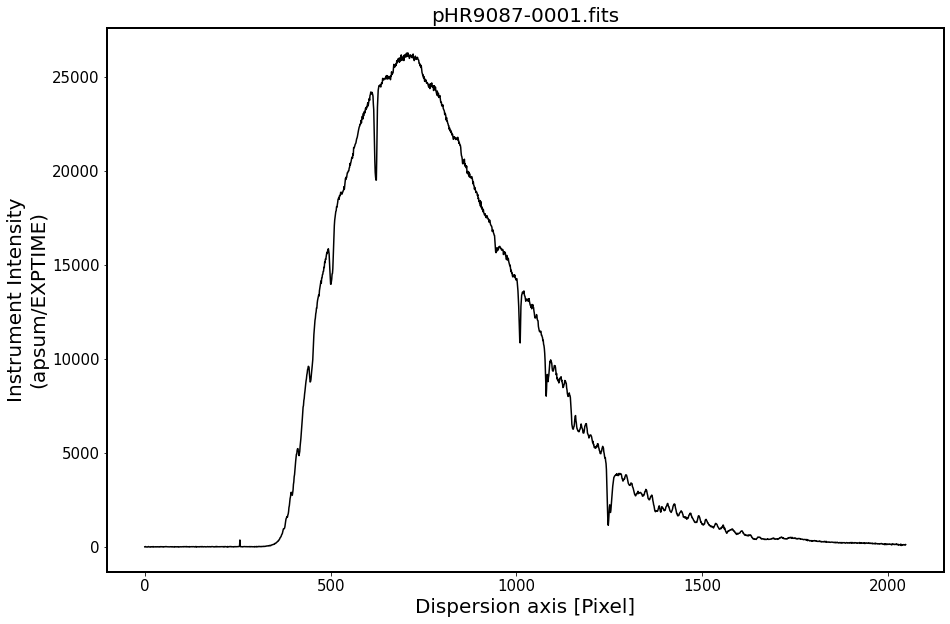

In [54]:
#Plot the spectrum 

x_pix = np.arange(len(obj[0]))

fig,ax = plt.subplots(1,1,figsize=(15,10))
ax.plot(x_pix,ap_summed,color='k',alpha=1)


FILENAME = os.path.basename(OBJECTNAME)
ax.set_title(FILENAME,fontsize=20)
ax.set_ylabel('Instrument Intensity\n(apsum/EXPTIME)',fontsize=20)
ax.set_xlabel(r'Dispersion axis [Pixel]',fontsize=20) 
ax.tick_params(labelsize=15)
plt.show()

spec_before_wfcali = Table([x_pix, ap_summed, ap_std],
                          names=['x_pix', 'ap_summed', 'ap_std'])


spec_before_wfcali.write(os.path.splitext(OBJECTNAME)[0]+'_inst_spec.csv',
                        overwrite=True, format='csv')

# 2-2. Wavelength calibration

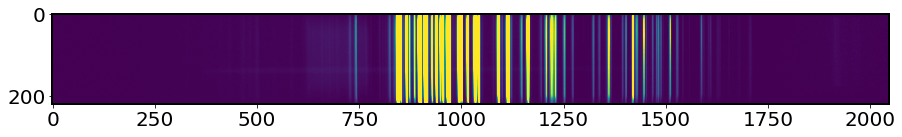

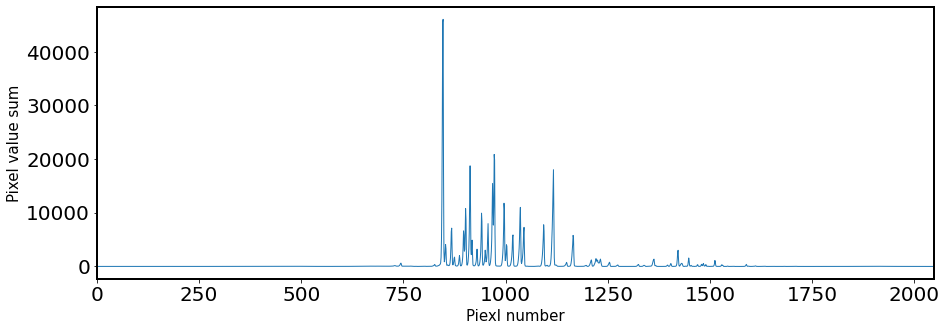

<Figure size 432x288 with 0 Axes>

In [2]:
#Bring the Master Comparison image
Master_comparison = os.path.join(subpath,'pMaster_Neon.fits')
compimage = fits.open(Master_comparison)[0].data
identify = np.median(compimage[90:110,:],
                         axis=0)
fig,ax = fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.imshow(compimage, vmin=0, vmax=1000)

fig,ax = plt.subplots(1,1,figsize=(15,5))
x_identify = np.arange(0,len(identify))
ax.plot(x_identify,identify,lw=1)
ax.set_xlabel('Piexl number')
ax.set_ylabel('Pixel value sum')
ax.set_xlim(0,len(identify))
plt.show()
plt.tight_layout()


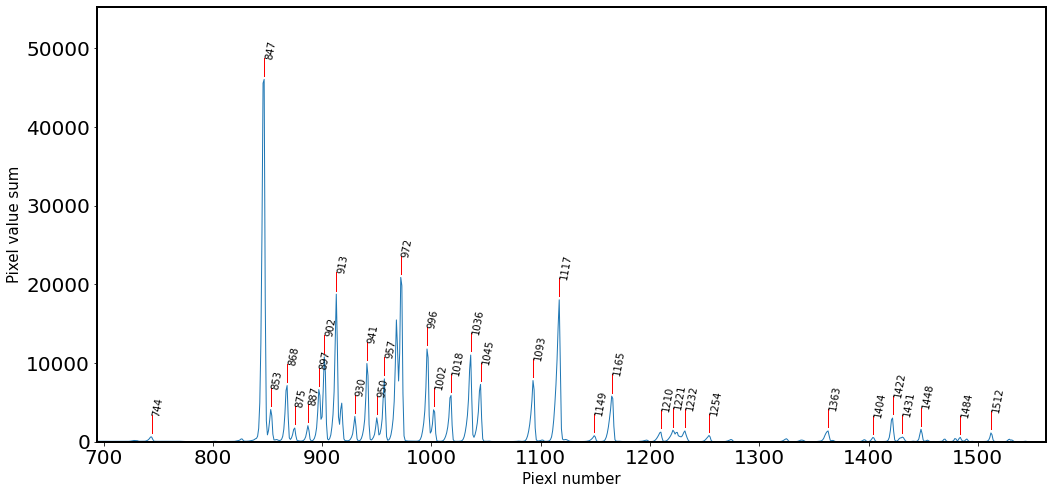

<Figure size 432x288 with 0 Axes>

In [5]:
#Find the local peak

peak_pix = peak_local_max(identify,
                          num_peaks = max(identify),
                          min_distance = 4,
                          threshold_abs= max(identify)*0.01)


fig,ax = plt.subplots(1,1,figsize=(17,8))
x_identify = np.arange(0,len(identify))
ax.plot(x_identify,identify,lw=1)
for i in peak_pix:
    ax.plot([i,i],
            [identify[i]+0.01*max(identify),identify[i]+0.06*max(identify)],
            color='r',lw=1)
    ax.annotate(i[0],(i,identify[i]+0.06*max(identify)),
                fontsize=10,
                rotation=80)

ax.set_xlabel('Piexl number')
ax.set_ylabel('Pixel value sum')
ax.set_xlim(min(peak_pix)[0] - 50,max(peak_pix)[0] + 50)
ax.set_ylim(-20,max(identify) + max(identify)*0.2)
plt.show()
plt.tight_layout()

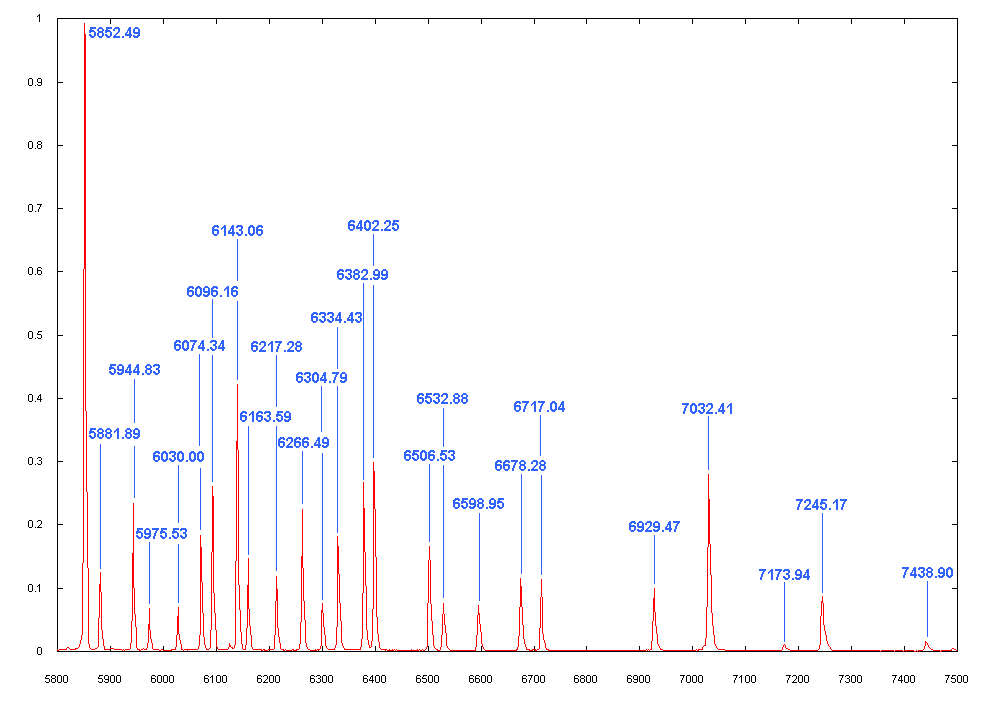

In [6]:
#Comparison Lampe line list

LISTFILE = os.path.join(subpath,'neon1.gif')
Image(filename = LISTFILE, width=800)
#http://astrosurf.com/buil/us/spe2/hresol4.htm

4334.218941926441


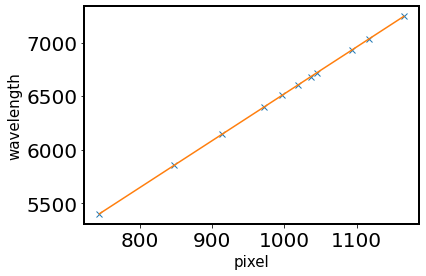

In [7]:
#Find the matching pair of wavelength and pixel
ID_init = dict(pixel_init = [744,847,913,972,
                             996,1018,1036,1045,
                             1093,1117,1165],
            wavelength = [5400.562,5852.49,6143.06,6402.25,
                          6506.53,6598.95,6678.28,6717.04,
                          6929.47,7032.41,7245.17])

# ID_init = dict(pixel_init = [500,847,913,972,
#                              996,1018,1036,1045,
#                              1093,1117,1165,
#                              1363],
#             wavelength = [4264.40,5852.49,6143.06,6402.25,
#                           6506.53,6598.95,6678.28,6717.04,
#                           6929.47,7032.41,7245.17,8108.99])



ID_init = Table(ID_init)
plt.plot(ID_init['pixel_init'],ID_init['wavelength'],marker='x',ls='')

def linear(x,a,b):
    return a*x + b
popt,pcov = curve_fit(linear,ID_init['pixel_init'],ID_init['wavelength'])
plt.plot(ID_init['pixel_init'],linear(ID_init['pixel_init'],*popt))
plt.xlabel('pixel')
plt.ylabel('wavelength')
print(linear(500,*popt))


In [8]:
#Fit the each peak with Gaussian 1D function

peak_gauss = []
fitter = LevMarLSQFitter()
LINE_FITTER = LevMarLSQFitter()
FWHM_ID = 3
x_identify = np.arange(0,len(identify))

#Gaussian fitting for each peak (pixel)
for peak_pix in ID_init['pixel_init']:
    g_init = Gaussian1D(amplitude = identify[peak_pix],
                        mean = peak_pix,
                        stddev = FWHM_ID*gaussian_fwhm_to_sigma,
                        bounds={'amplitude':(0,2*identify[peak_pix]),
                                'mean':(peak_pix - FWHM_ID,peak_pix + FWHM_ID),
                                'stddev':(0,FWHM_ID)})
    fitted = LINE_FITTER(g_init,x_identify,identify) #Model, x, y
    peak_gauss.append(fitted.mean.value)
    print(peak_pix,'->',fitted.mean.value)
    
    
peak_gauss = Column(data=peak_gauss,
                        name='pixel_gauss',
                        dtype=float)    
peak_shift = Column(data=peak_gauss - ID_init['pixel_init'],
                    name='piexl_shift',
                    dtype=float) 
ID_init['pixel_gauss'] = peak_gauss
ID_init['pixel_shift'] = peak_gauss - ID_init['pixel_init']
ID_init.sort('wavelength')
ID_init.pprint()

744 -> 743.2360879408903
847 -> 846.3183736257947
913 -> 912.884054646094
972 -> 970.589022151405
996 -> 996.1572260921837
1018 -> 1017.3067591489324
1036 -> 1035.4435514658264
1045 -> 1044.3308647874376
1093 -> 1092.876039266846
1117 -> 1116.287943737684
1165 -> 1164.8797595654823
pixel_init wavelength    pixel_gauss         pixel_shift     
---------- ---------- ------------------ --------------------
       744   5400.562  743.2360879408903  -0.7639120591096571
       847    5852.49  846.3183736257947  -0.6816263742052797
       913    6143.06   912.884054646094 -0.11594535390599958
       972    6402.25   970.589022151405  -1.4109778485950528
       996    6506.53  996.1572260921837  0.15722609218369143
      1018    6598.95 1017.3067591489324  -0.6932408510675714
      1036    6678.28 1035.4435514658264   -0.556448534173569
      1045    6717.04 1044.3308647874376  -0.6691352125624235
      1093    6929.47  1092.876039266846 -0.12396073315403555
      1117    7032.41  1116.2879437

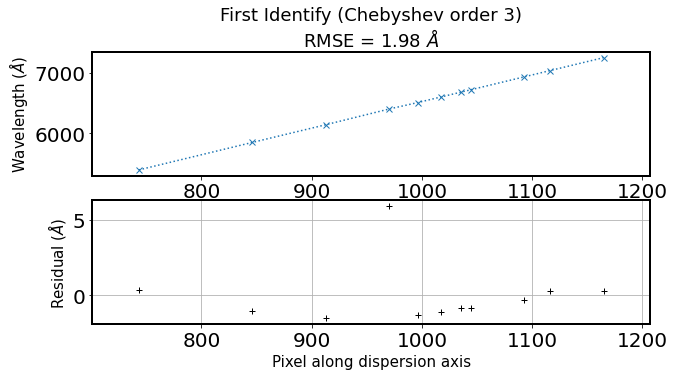

In [10]:
#Derive dispersion solution

ORDER_ID = 3 #Order of fitting function #보통 3 이하로 함. 기기의 사용파장대가 넓으면 4를 사용할때도 있음. 
coeff_ID, fitfull = chebfit(ID_init['pixel_gauss'],
                           ID_init['wavelength'],
                           deg=ORDER_ID,
                           full=True)  #Derive the dispersion solution

fitRMS = np.sqrt(fitfull[0][0]/len(ID_init))
rough_error = ((max(ID_init['wavelength'])-min(ID_init['wavelength']))
               /(max(ID_init['pixel_gauss'])-min(ID_init['pixel_gauss'])))/2
residual = (ID_init['wavelength'] #wavelength from reference
            -chebval(ID_init['pixel_gauss'],coeff_ID)) #wavelength derived from fitting
res_range = np.max(np.abs(residual))

fig,ax = plt.subplots(2,1,figsize=(10,5))
ax[0].plot(ID_init['pixel_gauss'],
         ID_init['wavelength'],
         ls = ':',marker='x')
ax[1].plot(ID_init['pixel_gauss'],
          residual,
          ls='',marker='+',
          color='k')
max_ID_init = max(ID_init['pixel_gauss'])
min_ID_init = min(ID_init['pixel_gauss'])
fig_xspan = max_ID_init - min_ID_init
fig_xlim = np.array([min_ID_init, max_ID_init]) + np.array([-1,1])*fig_xspan*0.1
ax[1].set_xlim(fig_xlim)
ax[0].set_xlim(fig_xlim)
ax[0].set_ylabel(r'Wavelength ($\AA$)')
ax[1].set_ylabel(r'Residual ($\AA$)')
ax[1].set_xlabel('Pixel along dispersion axis')
ax[0].set_title('First Identify (Chebyshev order {:d})\n'.format(ORDER_ID) 
              + r'RMSE = {:.2f} $\AA$'.format(fitRMS))
ax[1].grid()
plt.show()

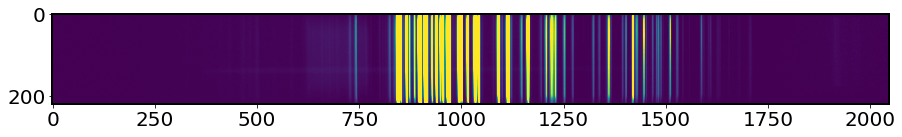

In [11]:
fig,ax = fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.imshow(compimage,vmin=0,vmax=1000)


In [12]:
#REIDENTIFY 

STEP_AP = 5 #Step size in pixel (dispersion direction)
STEP_REID = 10 #Step size in pixel (spatial direction)
N_SPATIAL,N_WAVELEN = np.shape(compimage) #(220, 2048)
N_REID = N_SPATIAL//STEP_REID #Spatial direction 
N_AP = N_WAVELEN//STEP_AP #Dispersion direction
TOL_REID = 5 # tolerence to lose a line in pixels

ORDER_WAVELEN_REID = 3 
ORDER_SPATIAL_REID = 3

line_REID = np.zeros((N_REID-1,len(ID_init))) #Make the empty array (height, width)
spatialcoord = np.arange(0,(N_REID-1)*STEP_REID,STEP_REID) + STEP_REID/2
# spatialcoord = array([  5.,  15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95., 105.,
#       115., 125., 135., 145., 155., 165., 175., 185., 195., 205.])




#Repeat we did above along the spatial direction
for i in range(0,N_REID-1): 
    lower_cut = i*STEP_REID
    upper_cut = (i+1)*STEP_REID
    reidentify_i = np.sum(compimage[lower_cut:upper_cut,:],axis=0)

    peak_gauss_REID = [] 
    
    for peak_pix_init in ID_init['pixel_gauss']:
        search_min = int(np.around(peak_pix_init - TOL_REID))
        search_max = int(np.around(peak_pix_init + TOL_REID))
        cropped = reidentify_i[search_min:search_max]
        x_cropped = np.arange(len(cropped)) + search_min

        #Fitting the initial gauss peak by usijng Gausian1D
        Amplitude_init = np.max(cropped)
        mean_init = peak_pix_init
        stddev_init = 5*gaussian_fwhm_to_sigma
        g_init = Gaussian1D(amplitude = Amplitude_init,
                           mean = mean_init,
                           stddev = stddev_init,
                           bounds={'amplitude':(0, 2*np.max(cropped)) ,
                                 'stddev':(0, TOL_REID)})
        g_fit = fitter(g_init,x_cropped,cropped)
        fit_center = g_fit.mean.value    
        if abs(fit_center - peak_pix_init) > TOL_REID: #스펙트럼 끝에서는 잘 안 잡힐수있으니까
            peak_gauss_REID.append(np.nan)
            continue
        else:
            peak_gauss_REID.append(fit_center)
            
    peak_gauss_REID = np.array(peak_gauss_REID)  
    nonan_REID = np.isfinite(peak_gauss_REID)
    line_REID[i,:] = peak_gauss_REID  
    peak_gauss_REID_nonan = peak_gauss_REID[nonan_REID] 
    n_tot = len(peak_gauss_REID)
    n_found = np.count_nonzero(nonan_REID)
    coeff_REID1D, fitfull = chebfit(peak_gauss_REID_nonan,
                                    ID_init['wavelength'][nonan_REID], 
                                    deg=ORDER_WAVELEN_REID,
                                    full=True)
    fitRMS = np.sqrt(fitfull[0][0]/n_found)
    
points = np.vstack((line_REID.flatten(),
                    np.tile(spatialcoord, len(ID_init['pixel_init']))))
#np.tile(A,reps):Construct an array by repeating A the number of times given by reps.
# a = np.array([1, 2, 3])
# b = np.array([2, 3, 4])
# np.vstack((a,b)) = array([[1, 2, 3],[2, 3, 4]])
points = points.T # list of ()  
                   

values = np.tile(ID_init['wavelength'], N_REID - 1) #Wavelength corresponding to each point
values = np.array(values.tolist())  #
# errors = np.ones_like(values)


# #Fitting the wavelength along spatial direction and dispertion direction 
coeff_init = Chebyshev2D(x_degree=ORDER_WAVELEN_REID, y_degree=ORDER_SPATIAL_REID)
fit2D_REID = fitter(coeff_init, points[:, 0], points[:, 1], values) 
#Dispersion solution (both spatial & dispersion) #fitter(order,x,y,f(x,y))

Text(0.5, 0.98, 'Reidentify and Wavelength Map\nfunc=Chebyshev, order (wavelength, dispersion) = (3, 3)')

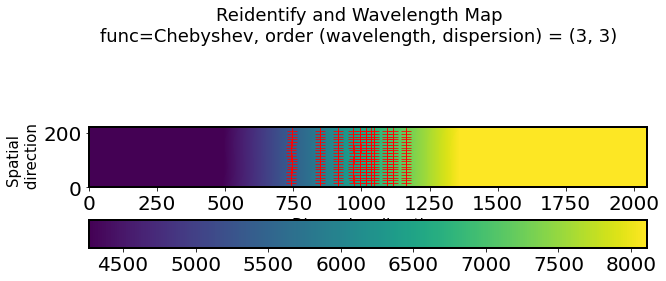

In [13]:
#Plot 2D wavelength callibration map and #Points to used re-identify

fig,ax = plt.subplots(1,1,figsize=(10,4))
ww, ss = np.mgrid[:N_WAVELEN, :N_SPATIAL]
im = ax.imshow(fit2D_REID(ww, ss).T, origin='lower',vmin=4264.4,vmax=8108.99)
ax.plot(points[:, 0], points[:, 1], ls='', marker='+', color='r',
             alpha=0.8, ms=10)
fig.colorbar(im, ax=ax,orientation = 'horizontal')

ax.set_ylabel('Spatial \n direction')
ax.set_xlabel('Dispersion direction')
title_str = ('Reidentify and Wavelength Map\n'
+ 'func=Chebyshev, order (wavelength, dispersion) = ({:d}, {:d})')


plt.suptitle(title_str.format(ORDER_WAVELEN_REID, ORDER_SPATIAL_REID))

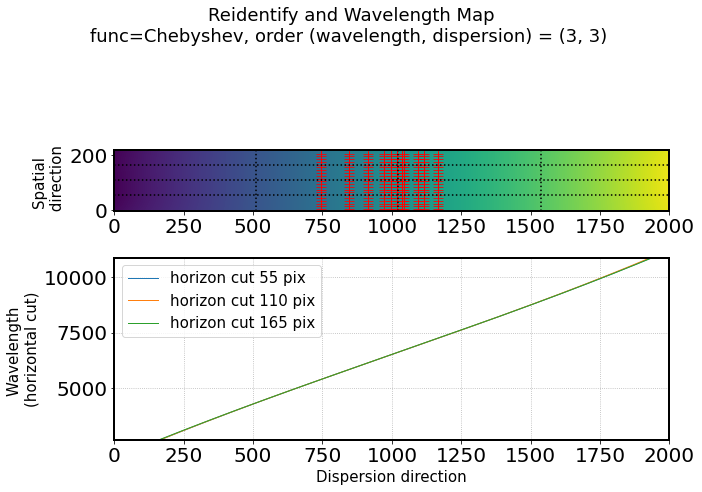

In [14]:
# Check how the dispersion solution change along the spatial axis
# Divide spectrum into 4 equal parts in the spatial direction

fig,ax = plt.subplots(2,1,figsize=(10,7))
ax[0].imshow(fit2D_REID(ww, ss).T, origin='lower')
ax[0].plot(points[:, 0], points[:, 1], ls='', marker='+', color='r',
             alpha=0.8, ms=10)
ax[0].set_xlim(0,2000)
ax[0].set_ylabel('Spatial \n direction')

title_str = ('Reidentify and Wavelength Map\n'
+ 'func=Chebyshev, order (wavelength, dispersion) = ({:d}, {:d}) \n')
plt.suptitle(title_str.format(ORDER_WAVELEN_REID, ORDER_SPATIAL_REID))


for i in (1, 2, 3):
    vcut = N_WAVELEN * i/4
    hcut = N_SPATIAL * i/4
    vcutax  = np.arange(0, N_SPATIAL, STEP_REID) + STEP_REID/2 #Spatial dir coordinate
    hcutax  = np.arange(0, N_WAVELEN, 1) # pixel along dispersion axis
    
    vcutrep = np.repeat(vcut, len(vcutax)) #i/4에 해당하는 dispersion pixel * len(spatial)
    hcutrep = np.repeat(hcut, len(hcutax)) #i/4에 해당하는 spatial pixel * len(dispersion)

    ax[0].axvline(x=vcut, ls=':', color='k')   
    ax[0].axhline(y=hcut, ls=':', color='k')

    ax[1].plot(hcutax, fit2D_REID(hcutax, hcutrep), lw=1, 
             label="horizon cut {:d} pix".format(int(hcut)))
ax[1].set_xlim(0,2000)

ax[1].grid(ls=':')
ax[1].legend()
ax[1].set_xlabel('Dispersion direction')
ax[1].set_ylabel('Wavelength \n(horizontal cut)')
ax[1].set_ylim(min(ID_init['wavelength'])*0.5,max(ID_init['wavelength'])*1.5)


plt.tight_layout()

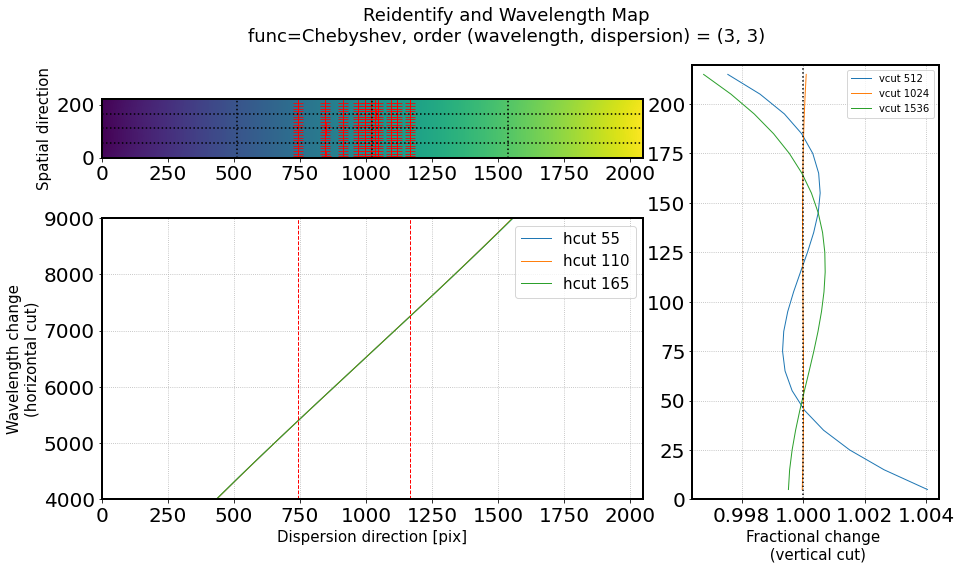

In [15]:
fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[:1, :2])
ax2 = plt.subplot(gs[1:3, :2])
ax3 = plt.subplot(gs[:3, 2])

#Title
title_str = ('Reidentify and Wavelength Map\n'
             + 'func=Chebyshev, order (wavelength, dispersion) = ({:d}, {:d})')
plt.suptitle(title_str.format(ORDER_WAVELEN_REID, ORDER_SPATIAL_REID))



interp_min = line_REID[~np.isnan(line_REID)].min()
interp_max = line_REID[~np.isnan(line_REID)].max()

ax1.imshow(fit2D_REID(ww, ss).T, origin='lower')
ax1.axvline(interp_max, color='r', lw=1)
ax1.axvline(interp_min, color='r', lw=1)
ax1.plot(points[:, 0], points[:, 1], ls='', marker='+', color='r',
             alpha=0.8, ms=10)
ax1.set_xlim(0,2000)
ax1.set_ylabel('Spatial \n direction')



for i in (1, 2, 3):
    vcut = N_WAVELEN * i/4
    hcut = N_SPATIAL * i/4
    vcutax  = np.arange(0, N_SPATIAL, STEP_REID) + STEP_REID/2
    hcutax  = np.arange(0, N_WAVELEN, 1)
    vcutrep = np.repeat(vcut, len(vcutax))
    hcutrep = np.repeat(hcut, len(hcutax))

    ax1.axvline(x=vcut, ls=':', color='k')   
    ax1.axhline(y=hcut, ls=':', color='k')

    ax2.plot(hcutax, fit2D_REID(hcutax, hcutrep), lw=1, 
             label="hcut {:d}".format(int(hcut)))

    
    vcut_profile = fit2D_REID(vcutrep, vcutax)
    vcut_normalize = vcut_profile / np.median(vcut_profile)
    
    ax3.plot(vcut_normalize, vcutax, lw=1,
             label="vcut {:d}".format(int(vcut)))



ax2.axvline(interp_max, color='r', lw=1,ls='--')
ax2.axvline(interp_min, color='r', lw=1,ls='--')    
    
ax1.set_ylabel('Spatial direction')
ax2.grid(ls=':')
ax2.legend(fontsize=15)
ax2.set_xlabel('Dispersion direction [pix]')
ax2.set_ylabel('Wavelength change\n(horizontal cut)')

ax3.axvline(1, ls=':', color='k')
ax3.grid(ls=':', which='both')
ax3.set_xlabel('Fractional change \n (vertical cut)')
ax3.legend(fontsize=10)

ax1.set_ylim(0, N_SPATIAL)
ax1.set_xlim(0, N_WAVELEN)
# ax2.set_xlim(300, 1700)
ax2.set_xlim(0, N_WAVELEN)
ax2.set_ylim(4000,9000)
ax3.set_ylim(0, N_SPATIAL)
plt.show()    




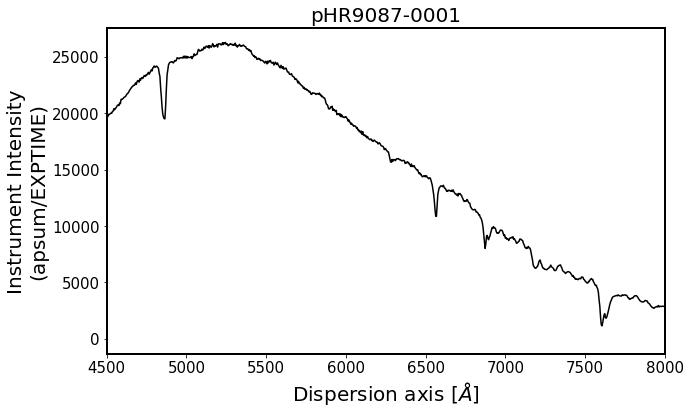

In [55]:
#Plot the spectrum respect to wavelength

Wavelength = chebval(np.arange(len(compimage[0])),coeff_ID)

x_pix = np.arange(len(obj[0]))

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(Wavelength,ap_summed,color='k',alpha=1)


FILENAME = OBJECTNAME.split('/')[-1].split('.')[0]
ax.set_title(FILENAME,fontsize=20)
ax.set_ylabel('Instrument Intensity\n(apsum/EXPTIME)',fontsize=20)
ax.set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax.tick_params(labelsize=15)
ax.set_xlim(4500,8000)
plt.show()



SAVE_FILENAME = os.path.join(subpath,FILENAME+'_w_spec.csv')

Data = [Wavelength,ap_summed,ap_std]
data = Table(Data, names=['wave','inten','std'])
data['wave'].format = "%.3f" 
data['inten'].format = "%.3f" 
data['std'].format = "%.3f" 

ascii.write(data,SAVE_FILENAME,overwrite=True,format='csv')

# 3. Flux calibration

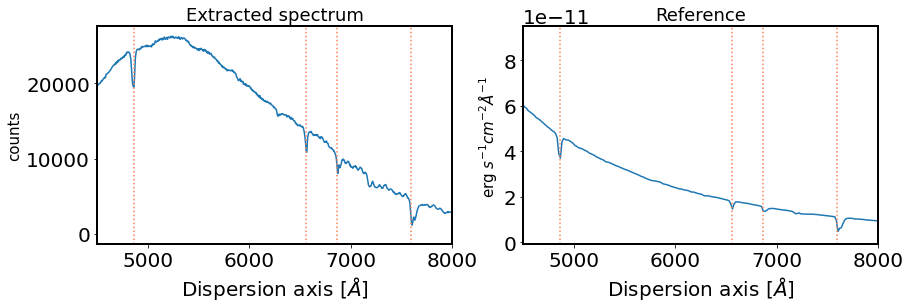

In [56]:
def _mag2flux(wave, mag, zeropt=48.60):
    '''
    Convert magnitudes to flux units. This is important for dealing with standards
    and files from IRAF, which are stored in AB mag units. To be clear, this converts
    to "PHOTFLAM" units in IRAF-speak. Assumes the common flux zeropoint used in IRAF

    Parameters
    ----------
    wave : 1d numpy array
        The wavelength of the data points
    mag : 1d numpy array
        The magnitudes of the data
    zeropt : float, optional
        Conversion factor for mag->flux. (Default is 48.60)

    Returns
    -------
    Flux values!
    '''

    c = 2.99792458e18 # speed of light, in A/s
    flux = 10.0**( (mag + zeropt) / (-2.5) )
    return flux * (c / wave**2.0)


stdfile = os.path.join(subpath,'hr9087.csv')
stddata = ascii.read(stdfile)
std_wave, std_mag, std_wth  = stddata['wave'],stddata['mag'],stddata['width']
std_flux = _mag2flux(std_wave,std_mag)


obj = ascii.read(os.path.join(subpath,'pHR9087-0001_w_spec.csv'))
obj_wave = obj['wave']
obj_flux = obj['inten']




fig,ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(obj_wave,obj_flux)
ax[0].set_xlim(4500,8000)
ax[0].set_title('Extracted spectrum')
ax[0].set_ylabel(r'counts')
ax[0].set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax[1].plot(std_wave,std_flux)
ax[1].set_xlim(4500,8000)
ax[1].set_title('Reference')
ax[1].set_ylabel(r'erg $s^{-1}cm^{-2}\AA^{-1}$ ')
ax[1].set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 


balmer = np.array([6563, 4861, 4341,4100,6867,7593.7], dtype='float')
for i in balmer:
    ax[0].axvline(i,color='coral',ls=':')
    ax[1].axvline(i,color='coral',ls=':')

Text(0, 0.5, '$\\log_{10} \\left( \\frac{reference}{Observed} \\right)$')

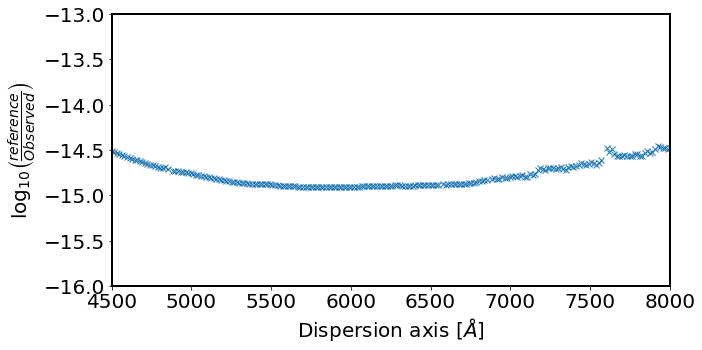

In [57]:
from scipy.interpolate import UnivariateSpline



obj_flux_ds = []
obj_wave_ds = []
std_flux_ds = []

for i in range(len(std_wave)):
    rng = np.where( (obj_wave >= std_wave[i] - std_wth[i] / 2.0) &
                           (obj_wave < std_wave[i] + std_wth[i] / 2.0)) #STD-wave 범위 안에 들어가는 obj_wave

    IsH = np.where((balmer >= std_wave[i] - std_wth[i] / 2.0) &
                           (balmer < std_wave[i] + std_wth[i] / 2.0))
    
    if (len(rng[0]) > 1) and (len(IsH[0]) == 0): 
        # does this bin contain observed spectra, and no Balmer line?
        # obj_flux_ds.append(np.sum(obj_flux[rng]) / std_wth[i])
        obj_flux_ds.append( np.nanmean(obj_flux[rng]) )
        obj_wave_ds.append(std_wave[i])
        std_flux_ds.append(std_flux[i])
        
ratio = np.abs(np.array(std_flux_ds, dtype='float') /
                       np.array(obj_flux_ds, dtype='float'))
LogSensfunc = np.log10(ratio)


fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(obj_wave_ds,LogSensfunc,marker='x',ls='')
ax.set_xlim(4500,8000)
ax.set_ylim(-16,-13)
ax.set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax.set_ylabel(r'$\log_{10} \left( \frac{reference}{Observed} \right)$',fontsize=20) 

Text(0, 0.5, '$\\log_{10} \\left( \\frac{reference}{Observed} \\right)$')

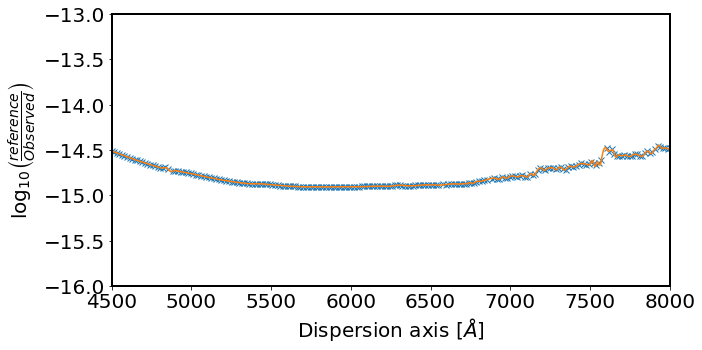

In [65]:
# interpolate back on to observed wavelength grid
spl = UnivariateSpline(obj_wave_ds, LogSensfunc, ext=0, k=2 ,s=0.0025)
sensfunc2 = spl(obj_wave)
# SF_CHEB_DEG = 5
# sf_coeff = chebfit(obj_wave_ds, LogSensfunc, deg=SF_CHEB_DEG)
# sensfunc2 = chebval(obj_wave, sf_coeff)

fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(obj_wave_ds,LogSensfunc,marker='x',ls='')
ax.plot(obj_wave,sensfunc2)
ax.set_xlim(4500,8000)
ax.set_ylim(-16,-13)
ax.set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax.set_ylabel(r'$\log_{10} \left( \frac{reference}{Observed} \right)$',fontsize=20) 

/tmp/ipykernel_2114072/192981939.py:1: RuntimeWarning: overflow encountered in power
  sensfunc = 10**sensfunc2


(0.0, 8e-11)

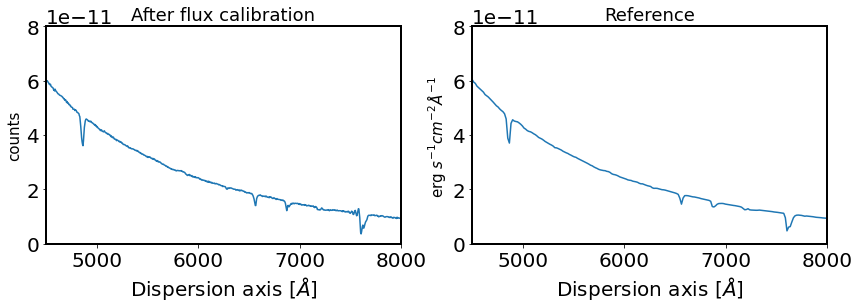

In [66]:
sensfunc = 10**sensfunc2
obj_cal = obj_flux*sensfunc #flux after flux calibration

fig,ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(obj_wave,obj_flux*sensfunc)
ax[0].set_xlim(4500,8000)
ax[0].set_title('After flux calibration')
ax[0].set_ylabel(r'counts')
ax[0].set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax[0].set_ylim(0,8*10**(-11))
ax[1].plot(std_wave,std_flux)
ax[1].set_xlim(4500,8000)
ax[1].set_title('Reference')
ax[1].set_ylabel(r'erg $s^{-1}cm^{-2}\AA^{-1}$ ')
ax[1].set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax[1].set_ylim(0,8*10**(-11))


In [67]:
Data = [ap_summed,  ap_std]

data = Table(Data, names=['inten','std'])
data['inten'].format = "%.3f" 
data['std'].format = "%.3f" 

SAVEFILE = os.path.join(subpath,'Spectrum.csv')
ascii.write(data,SAVEFILE,overwrite=True,format='csv')

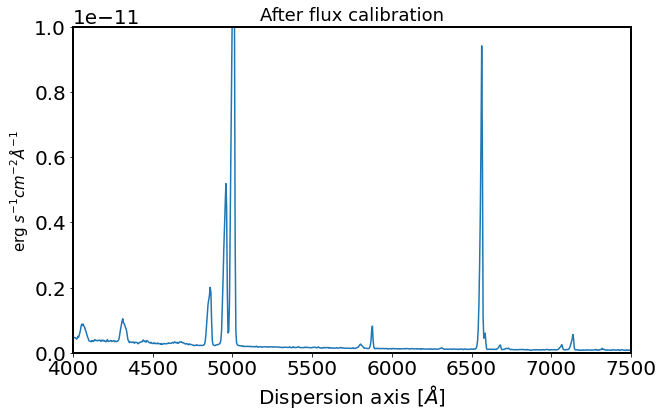

In [74]:
tar = ascii.read(os.path.join(subpath,'pNGC6543-0001_w_spec.csv'))
tar_wave = tar['wave']
tar_flux = tar['inten']
tar_cal = tar_flux*sensfunc #flux after flux calibration
tar_std = tar['std']*sensfunc

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(tar_wave,tar_cal)
ax.set_xlim(4000,7500)
ax.set_title('After flux calibration')
ax.set_ylabel(r'erg $s^{-1}cm^{-2}\AA^{-1}$ ')
ax.set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax.set_ylim(0,10*10**(-12))

spectrum = Table([tar_wave, tar_cal, tar_std],
                names=['wave', 'flux', 'error'])
spectrum['wave'].format = "%.3f" 
spectrum['flux'].format = "%.3e" 
spectrum['error'].format = "%.3e"

SPEC_SAVEPATH = os.path.splitext(OBJECTNAME)[0]+'_wf_spec.csv' 
spectrum.write(SPEC_SAVEPATH, overwrite=True, format='csv')